In [1]:
import pandas as pd
import glob
import os

def load_csv_files_from_folder(folder_path):

    csv_files = glob.glob(os.path.join(folder_path, '*.csv'))
    loaded_dataframes = []

    if not csv_files:
        # Minimal report: only if no files are found at all
        print(f"No CSV files found in '{folder_path}'.")
        return loaded_dataframes

    for file_path in csv_files:
        try:
            df = pd.read_csv(file_path)
            loaded_dataframes.append(df)
        except Exception:
            # Minimal error handling: simply skip the file and do not report details
            pass # No action/report as requested ("just do only that")

    return loaded_dataframes

# --- Execution ---
yfinance_data_folder = '../data/yfinance_data/' 

# Load all CSVs into a list of DataFrames
all_yfinance_dfs = load_csv_files_from_folder(yfinance_data_folder)


print(f"Successfully loaded {len(all_yfinance_dfs)} DataFrames.")
if all_yfinance_dfs:
    print("\nHead of the first loaded DataFrame:")
    print(all_yfinance_dfs[0].head())

Successfully loaded 7 DataFrames.

Head of the first loaded DataFrame:
         Date      Open      High       Low     Close  Adj Close      Volume  \
0  1986-03-13  0.088542  0.101563  0.088542  0.097222   0.059946  1031788800   
1  1986-03-14  0.097222  0.102431  0.097222  0.100694   0.062087   308160000   
2  1986-03-17  0.100694  0.103299  0.100694  0.102431   0.063158   133171200   
3  1986-03-18  0.102431  0.103299  0.098958  0.099826   0.061552    67766400   
4  1986-03-19  0.099826  0.100694  0.097222  0.098090   0.060482    47894400   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  


In [2]:
import pandas as pd

# Define ALL the required columns for each DataFrame
REQUIRED_COLUMNS = [
    'Date', 'Open', 'High', 'Low', 'Close', 'Adj Close',
    'Volume', 'Dividends', 'Stock Splits'
]

# Define a mapping for common alternative column names to standard names
COLUMN_NAME_MAPPING = {
    'date': 'Date',
    'open': 'Open',
    'high': 'High',
    'low': 'Low',
    'close': 'Close',
    'adj close': 'Adj Close',
    'adj_close': 'Adj Close',
    'volume': 'Volume',
    'vol': 'Volume',
    'dividends': 'Dividends',
    'dividend': 'Dividends',
    'stock splits': 'Stock Splits',
    'stock_splits': 'Stock Splits'
}

# --- Function to process each DataFrame ---
def standardize_df_columns(df, required_cols, col_mapping):

    # 1. Standardize column names (lowercase original names first for mapping)
    df.columns = df.columns.str.lower()
    df.rename(columns=col_mapping, inplace=True)

    # 2. Add missing required columns with pd.NA
    for col in required_cols:
        if col not in df.columns:
            df[col] = pd.NA

    # 3. Select ONLY the required columns and reorder them
    # This automatically drops any columns not in `required_cols`
    df = df[required_cols]

    return df

# --- Process all loaded DataFrames ---
# This list will store your DataFrames after column standardization
processed_yfinance_dfs = []

# Loop through each DataFrame loaded in the previous step
for df in all_yfinance_dfs:
    try:
        # Process the DataFrame
        processed_df = standardize_df_columns(df.copy(), REQUIRED_COLUMNS, COLUMN_NAME_MAPPING)
        processed_yfinance_dfs.append(processed_df)
    except Exception:
        pass 

print(f"Finished processing {len(processed_yfinance_dfs)} DataFrames.")
if processed_yfinance_dfs:
    print("\nExample: Head of the first processed DataFrame:")
    print(processed_yfinance_dfs[0].head())
    print("\nExample: Columns of the first processed DataFrame:")
    print(processed_yfinance_dfs[0].columns.tolist())
    print("\nExample: Check shape and columns of all processed DFs:")
    for i, df in enumerate(processed_yfinance_dfs):
        print(f"DF {i+1}: Shape {df.shape}, Columns {df.columns.tolist()}")

Finished processing 7 DataFrames.

Example: Head of the first processed DataFrame:
         Date      Open      High       Low     Close  Adj Close      Volume  \
0  1986-03-13  0.088542  0.101563  0.088542  0.097222   0.059946  1031788800   
1  1986-03-14  0.097222  0.102431  0.097222  0.100694   0.062087   308160000   
2  1986-03-17  0.100694  0.103299  0.100694  0.102431   0.063158   133171200   
3  1986-03-18  0.102431  0.103299  0.098958  0.099826   0.061552    67766400   
4  1986-03-19  0.099826  0.100694  0.097222  0.098090   0.060482    47894400   

   Dividends  Stock Splits  
0        0.0           0.0  
1        0.0           0.0  
2        0.0           0.0  
3        0.0           0.0  
4        0.0           0.0  

Example: Columns of the first processed DataFrame:
['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'Dividends', 'Stock Splits']

Example: Check shape and columns of all processed DFs:
DF 1: Shape (9672, 9), Columns ['Date', 'Open', 'High', 'Low'

In [3]:
import pandas as pd
import talib as ta
import numpy as np

# Important Pre-computation Check (if not already done in previous steps) 
# Ensure 'Date' is set as index and sorted for all DFs, and OHLCV columns are numeric.
# This loop ensures the data is in the correct format for TA-Lib.
for i, df_stock in enumerate(all_yfinance_dfs):
    # Ensure 'Date' is datetime and set as index if it's still a column
    if 'Date' in df_stock.columns:
        df_stock['Date'] = pd.to_datetime(df_stock['Date'], errors='coerce')
        df_stock.dropna(subset=['Date'], inplace=True) # Remove rows where Date conversion failed
        df_stock.set_index('Date', inplace=True)
    
    # Crucial: Sort by index (Date) to ensure correct time-series calculation for TA-Lib
    df_stock.sort_index(inplace=True)

    # Ensure OHLCV columns are numeric (float) and handle potential NaNs
    numeric_cols = ['Open', 'High', 'Low', 'Close', 'Volume']
    for col in numeric_cols:
        if col in df_stock.columns:
            df_stock[col] = pd.to_numeric(df_stock[col], errors='coerce')
    df_stock.dropna(subset=numeric_cols, inplace=True) # Drop rows if core OHLCV values are missing after conversion


print("--- Applying SMA, RSI, and MACD Indicators using TA-Lib to each DataFrame ---")

# Loop through each DataFrame in your list of 7 datasets
for i, df_stock in enumerate(all_yfinance_dfs):
    ticker_name = df_stock['Ticker'].iloc[0] if 'Ticker' in df_stock.columns else f'DF_{i+1}'
    print(f"\nProcessing indicators for {ticker_name} (Original Shape: {df_stock.shape})...")

    # Extract necessary data for TA-Lib as NumPy arrays 
    close_prices = df_stock['Close'].values.astype(float)
   
    # Minimum data points required for MACD (which has the longest lookback here)
    min_data_points_required = 35 
    if len(df_stock) < min_data_points_required:
        print(f"  Warning: Not enough data points ({len(df_stock)}) in {ticker_name} for some indicators. Skipping TA-Lib calculations for this DataFrame.")
        continue 

    try:
        # 1. Simple Moving Average (SMA) - using a 20-period
        df_stock['SMA_20'] = ta.SMA(close_prices, timeperiod=20)

        # 2. Relative Strength Index (RSI) - using a 14-period
        df_stock['RSI_14'] = ta.RSI(close_prices, timeperiod=14)

        # 3. Moving Average Convergence Divergence (MACD)
        # Returns three arrays: MACD line, Signal line, and MACD Histogram
        macd, macdsignal, macdhist = ta.MACD(
            close_prices,
            fastperiod=12,
            slowperiod=26,
            signalperiod=9
        )
        df_stock['MACD'] = macd
        df_stock['MACD_Signal'] = macdsignal
        df_stock['MACD_Hist'] = macdhist

        print(f"  Successfully added SMA, RSI, and MACD to {ticker_name}. New shape: {df_stock.shape}")

    except Exception as e:
        print(f"  Error applying TA-Lib indicators to {ticker_name}: {e}")

# --- Verification: Display a sample of one of the modified DataFrames ---
print("\n--- Example of the first DataFrame (DF 1) after adding indicators ---")
if all_yfinance_dfs:
    print(all_yfinance_dfs[0].tail())
    print(f"\nNew columns added to DF 0: {all_yfinance_dfs[0].columns.tolist()}")
else:
    print("No DataFrames were processed. Please ensure 'all_yfinance_dfs' is populated.")

--- Applying SMA, RSI, and MACD Indicators using TA-Lib to each DataFrame ---

Processing indicators for DF_1 (Original Shape: (9672, 8))...
  Successfully added SMA, RSI, and MACD to DF_1. New shape: (9672, 13)

Processing indicators for DF_2 (Original Shape: (6421, 8))...
  Successfully added SMA, RSI, and MACD to DF_2. New shape: (6421, 13)

Processing indicators for DF_3 (Original Shape: (6846, 8))...
  Successfully added SMA, RSI, and MACD to DF_3. New shape: (6846, 13)

Processing indicators for DF_4 (Original Shape: (3545, 8))...
  Successfully added SMA, RSI, and MACD to DF_4. New shape: (3545, 13)

Processing indicators for DF_5 (Original Shape: (2926, 8))...
  Successfully added SMA, RSI, and MACD to DF_5. New shape: (2926, 13)

Processing indicators for DF_6 (Original Shape: (10998, 8))...
  Successfully added SMA, RSI, and MACD to DF_6. New shape: (10998, 13)

Processing indicators for DF_7 (Original Shape: (5020, 8))...
  Successfully added SMA, RSI, and MACD to DF_7. New 

In [4]:
import pandas as pd
import numpy as np

print("--- Calculating Performance & Risk Metrics (using Pandas & NumPy) ---")

if 'all_yfinance_dfs' not in locals() or not all_yfinance_dfs:
    print("Error: 'all_yfinance_dfs' is not loaded or is empty.")
    print("Please ensure your historical stock data is loaded into 'all_yfinance_dfs' before running this code.")
else:
    for i, df_stock in enumerate(all_yfinance_dfs):
        # Use .copy() to avoid SettingWithCopyWarning if you modify the DataFrame later
        df_stock_copy = df_stock.copy() 
        ticker = df_stock_copy['Ticker'].iloc[0] if 'Ticker' in df_stock_copy.columns else f'Stock_{i+1}'
        print(f"\nAnalyzing Financial Metrics for {ticker}...")

        # Ensure 'Close' column is numeric and handle potential NaNs from data loading
        if 'Close' not in df_stock_copy.columns:
            print(f"  Warning: 'Close' column not found in {ticker} DataFrame. Skipping.")
            continue
        df_stock_copy['Close'] = pd.to_numeric(df_stock_copy['Close'], errors='coerce')
        df_stock_copy.dropna(subset=['Close'], inplace=True)

        if df_stock_copy.empty:
            print(f"  Warning: {ticker} DataFrame is empty after cleaning. Skipping.")
            continue
            
        # --- 1. Daily Returns ---
        df_stock_copy['Daily_Return'] = df_stock_copy['Close'].pct_change()
        # Drop the first NaN value that results from pct_change.
        df_stock_copy.dropna(subset=['Daily_Return'], inplace=True) 

        if df_stock_copy['Daily_Return'].empty:
            print(f"  Warning: Not enough data points to calculate returns for {ticker}. Skipping financial metrics.")
            continue

        print(f"\n  1. Daily Returns (last 3):")
        print(df_stock_copy['Daily_Return'].tail(3).to_string())
        print("     Interpretation: Percentage change in price from one day to the next.")

        # --- 2. Cumulative Returns ---
        # Calculate the cumulative product of (1 + Daily_Return) and then subtract 1.
        df_stock_copy['Cumulative_Return'] = (1 + df_stock_copy['Daily_Return']).cumprod() - 1
        
        print(f"\n  2. Cumulative Returns (last 3):")
        print(df_stock_copy[['Cumulative_Return']].tail(3).to_string())
        print("     Interpretation: Total percentage growth/loss from the start of the data.")

        # --- 3. Volatility (Annualized Standard Deviation of Daily Returns) ---
        # Calculate standard deviation of daily returns and annualize it.
        daily_volatility = df_stock_copy['Daily_Return'].std()
        annualized_volatility = daily_volatility * np.sqrt(252) # 252 trading days in a year

        print(f"\n  3. Annualized Volatility: {annualized_volatility:.4f} ({annualized_volatility*100:.2f}%)")
        print("     Interpretation: Higher is riskier; shows how much price fluctuates annually.")

        # --- 4. Maximum Drawdown (MDD) ---
        # Calculate the running maximum (peak) of the cumulative returns
        # Using (1 + Daily_Return).cumprod() to get the wealth index, starting from 1.0
        wealth_index = (1 + df_stock_copy['Daily_Return']).cumprod() 
        
        running_max = wealth_index.expanding().max()
        
        # Drawdown is (current wealth / running max) - 1
        drawdown = (wealth_index / running_max) - 1
        
        # The maximum drawdown is the most negative value in the drawdown series
        max_drawdown = drawdown.min()

        print(f"\n  4. Maximum Drawdown: {max_drawdown:.4f} ({max_drawdown*100:.2f}%)")
        print("     Interpretation: The largest peak-to-trough percentage drop in the stock's value.")

        # --- 5. Compound Annual Growth Rate (CAGR) ---
        # CAGR = ((Ending Value / Beginning Value)^(1/Number of Years)) - 1
        # Number of trading days in the period
        num_trading_days = len(df_stock_copy['Daily_Return'])
        
        # Total return over the period (last value of (1 + Daily_Return).cumprod() - 1)
        total_return = df_stock_copy['Cumulative_Return'].iloc[-1]
        
        # Number of years in the period
        # Avoid division by zero if less than a year of data
        num_years = num_trading_days / 252.0 if num_trading_days > 0 else 0
        
        cagr = 0.0
        if num_years > 0: # Ensure we have at least some data to calculate CAGR
            # CAGR = ((1 + total_return)^(1/num_years)) - 1
            # We use (1 + total_return) because total_return is already (Ending/Beginning - 1)
            # So (1 + total_return) = Ending/Beginning
            cagr = ((1 + total_return)**(1 / num_years)) - 1
        
        print(f"\n  5. Compound Annual Growth Rate (CAGR): {cagr:.4f} ({cagr*100:.2f}%)")
        print("     Interpretation: The average annual growth rate if compounded over the entire period.")

        print(f"\n--- Finished metrics for {ticker} ---")

--- Calculating Performance & Risk Metrics (using Pandas & NumPy) ---

Analyzing Financial Metrics for Stock_1...

  1. Daily Returns (last 3):
Date
2024-07-26    0.016420
2024-07-29    0.003433
2024-07-30   -0.008928
     Interpretation: Percentage change in price from one day to the next.

  2. Cumulative Returns (last 3):
            Cumulative_Return
Date                         
2024-07-26        4373.215583
2024-07-29        4388.232986
2024-07-30        4349.044351
     Interpretation: Total percentage growth/loss from the start of the data.

  3. Annualized Volatility: 0.3354 (33.54%)
     Interpretation: Higher is riskier; shows how much price fluctuates annually.

  4. Maximum Drawdown: -0.7456 (-74.56%)
     Interpretation: The largest peak-to-trough percentage drop in the stock's value.

  5. Compound Annual Growth Rate (CAGR): 0.2440 (24.40%)
     Interpretation: The average annual growth rate if compounded over the entire period.

--- Finished metrics for Stock_1 ---

Ana

--- Creating Visualizations for Stock Data and Indicators ---

Generating visualizations for Stock_1...


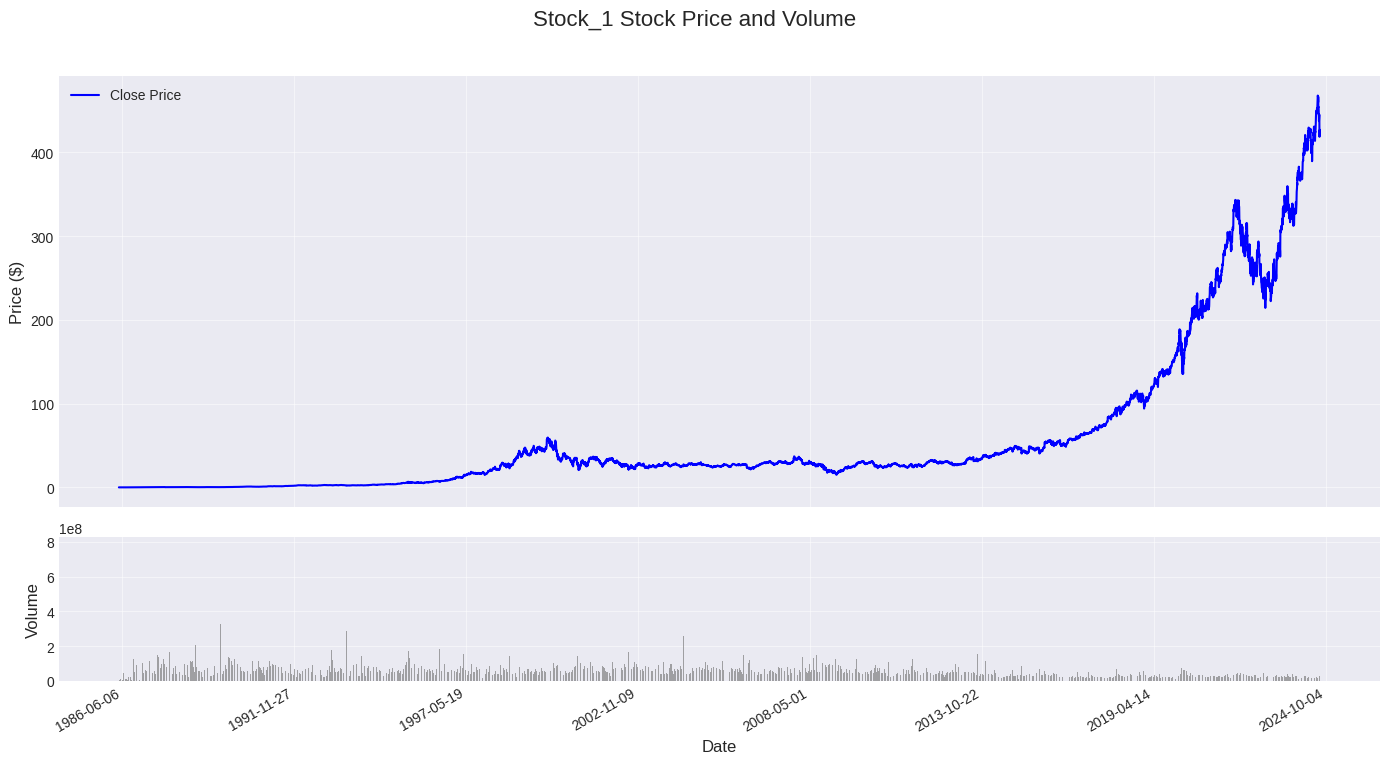

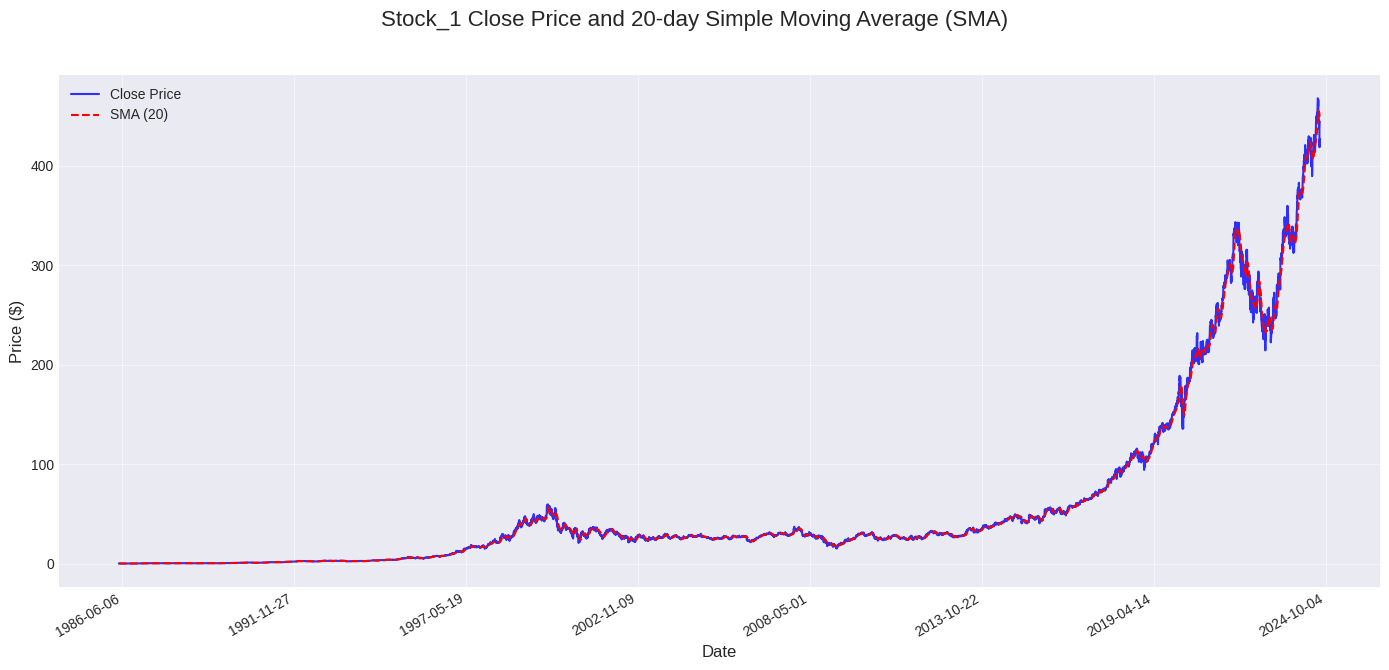

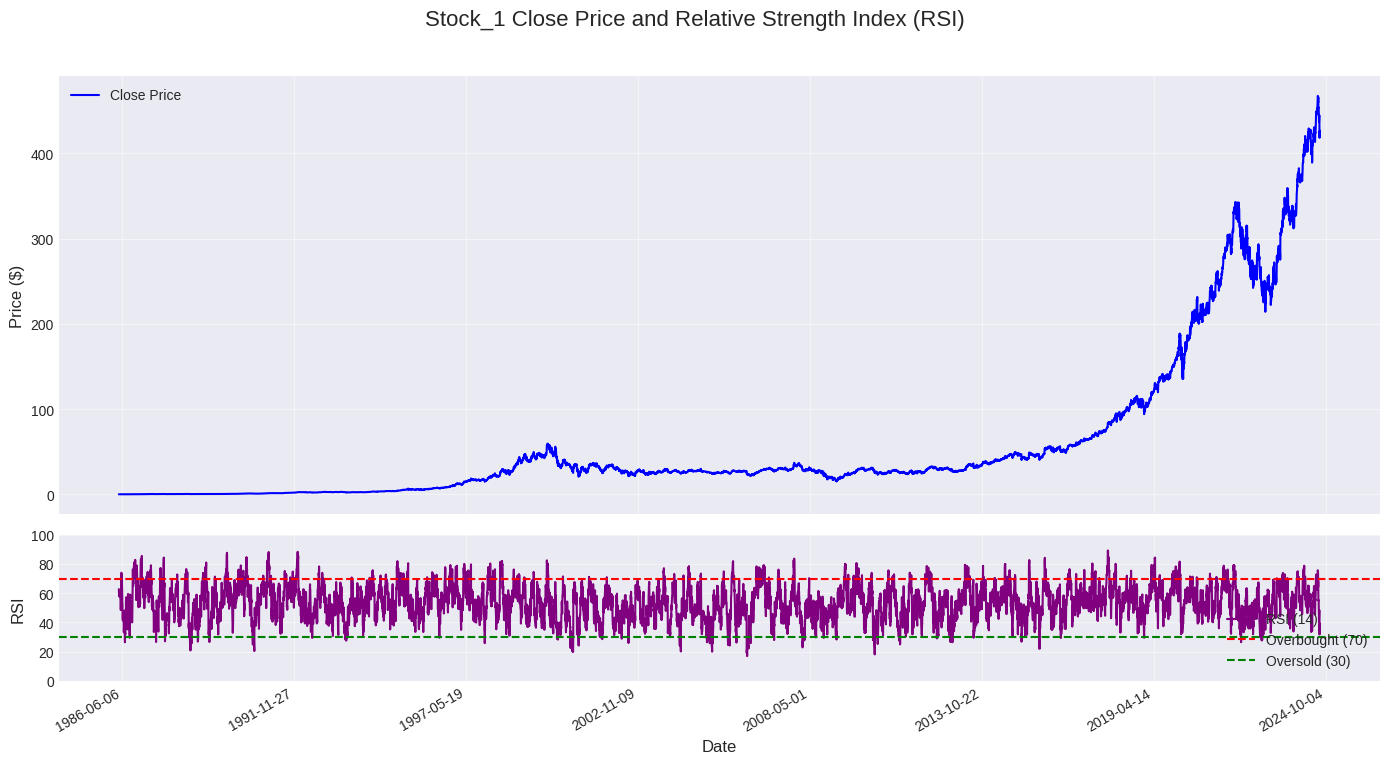

/tmp/ipykernel_3923/27112586.py:143: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])
/home/ca/code/KAIM/sentiment-vs-stock_market/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


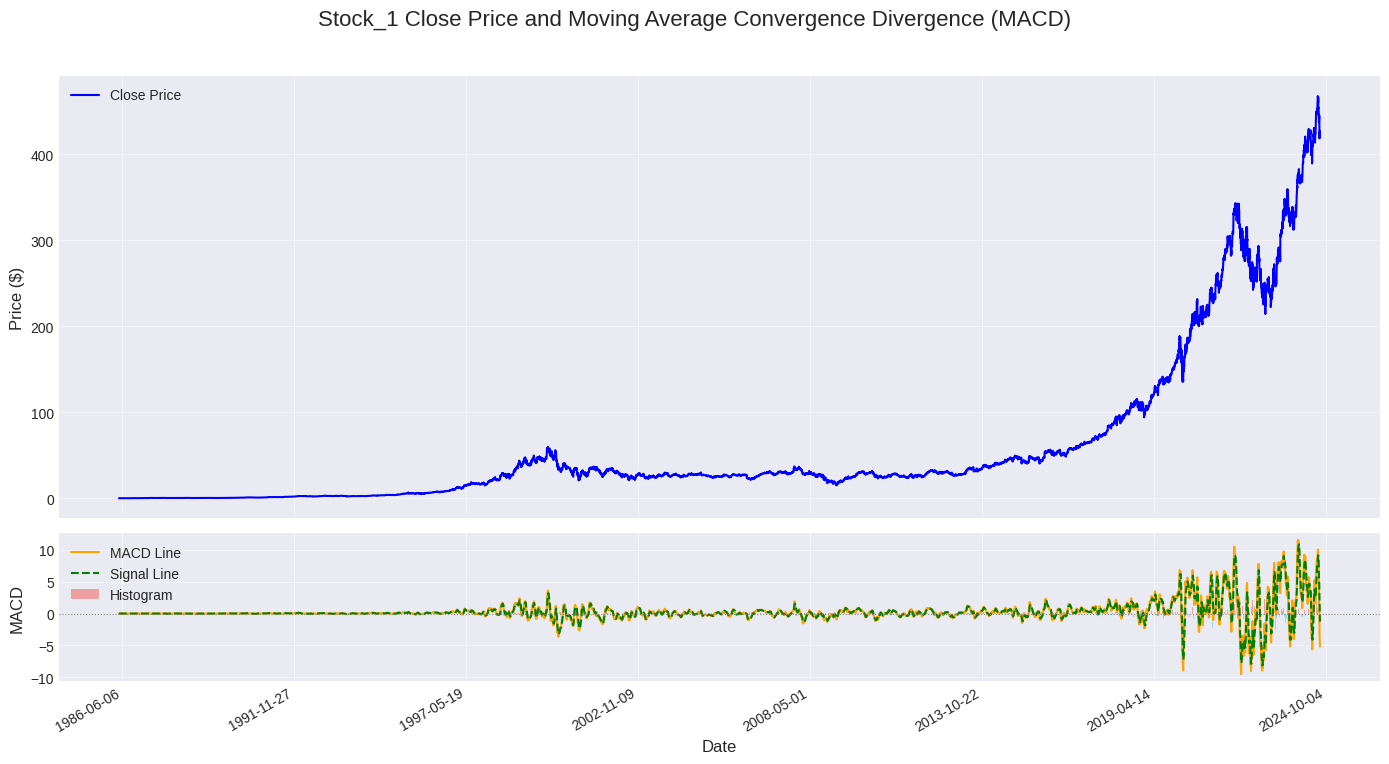

  Visualizations generated for Stock_1.

Generating visualizations for Stock_2...


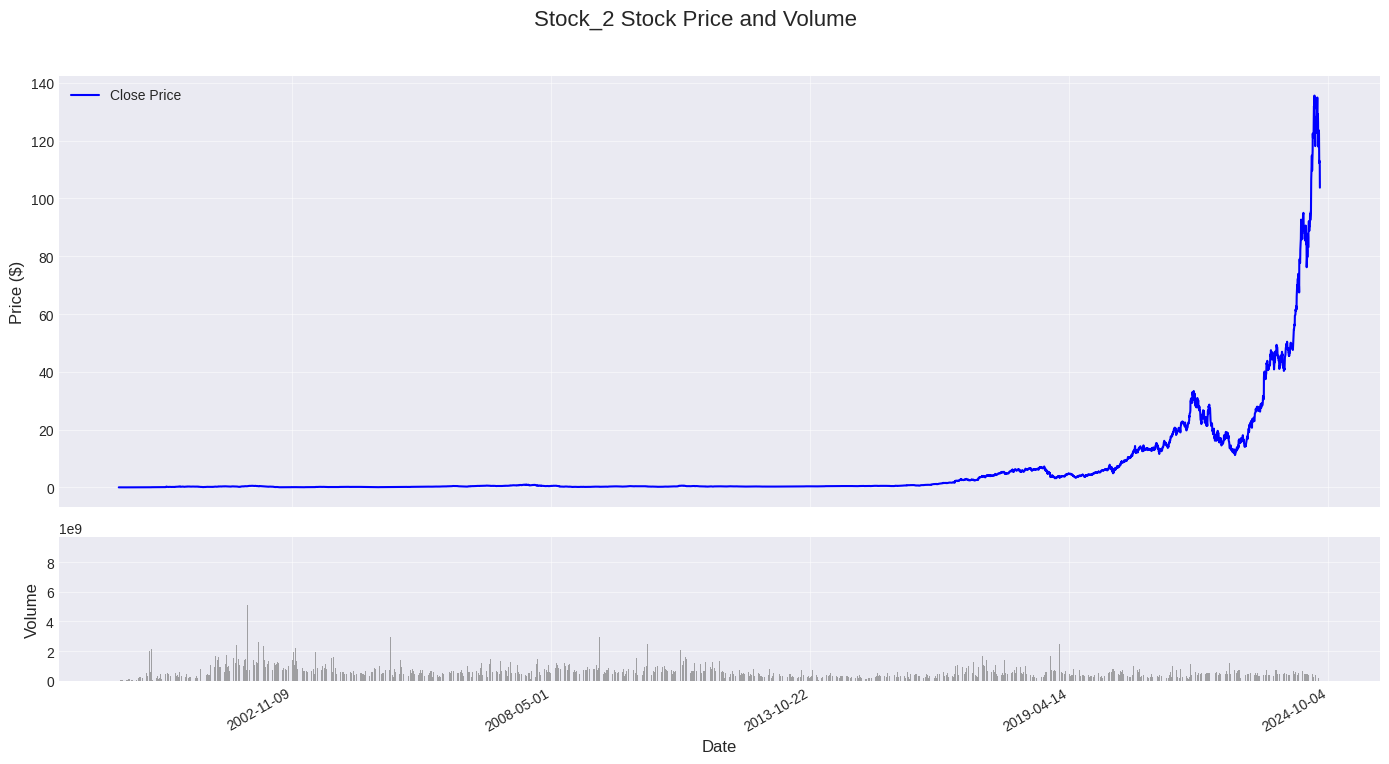

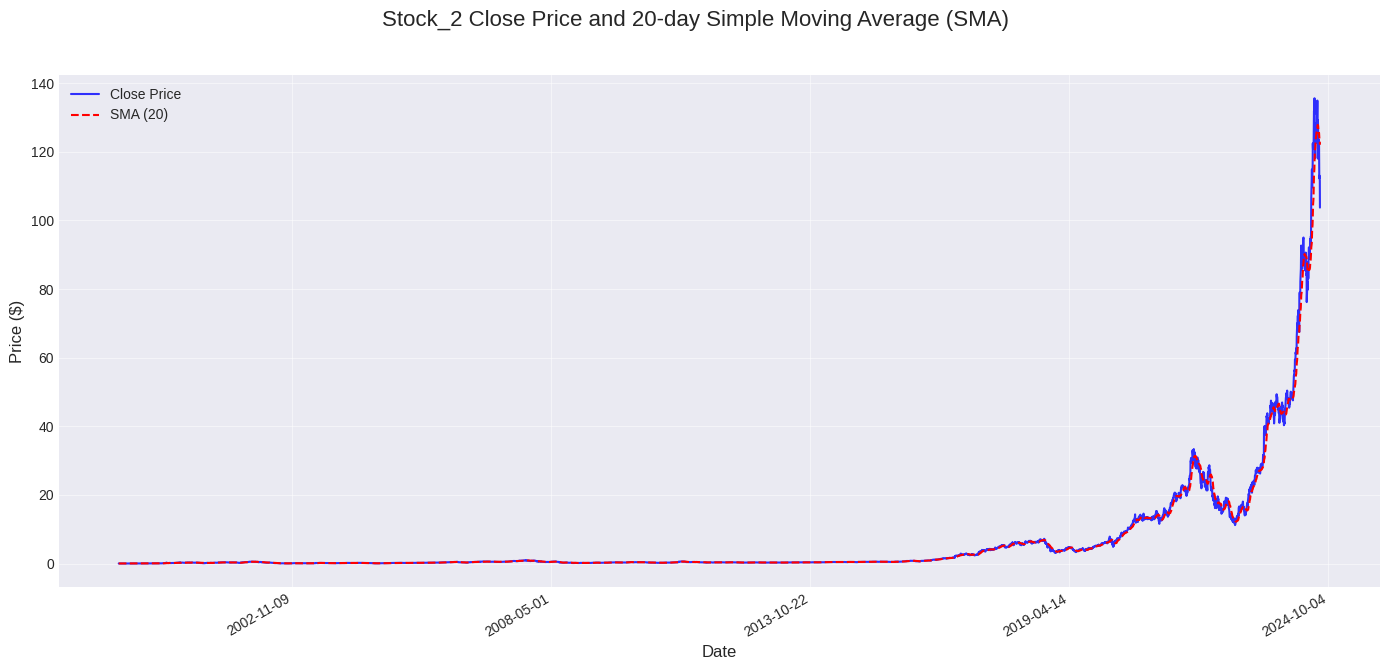

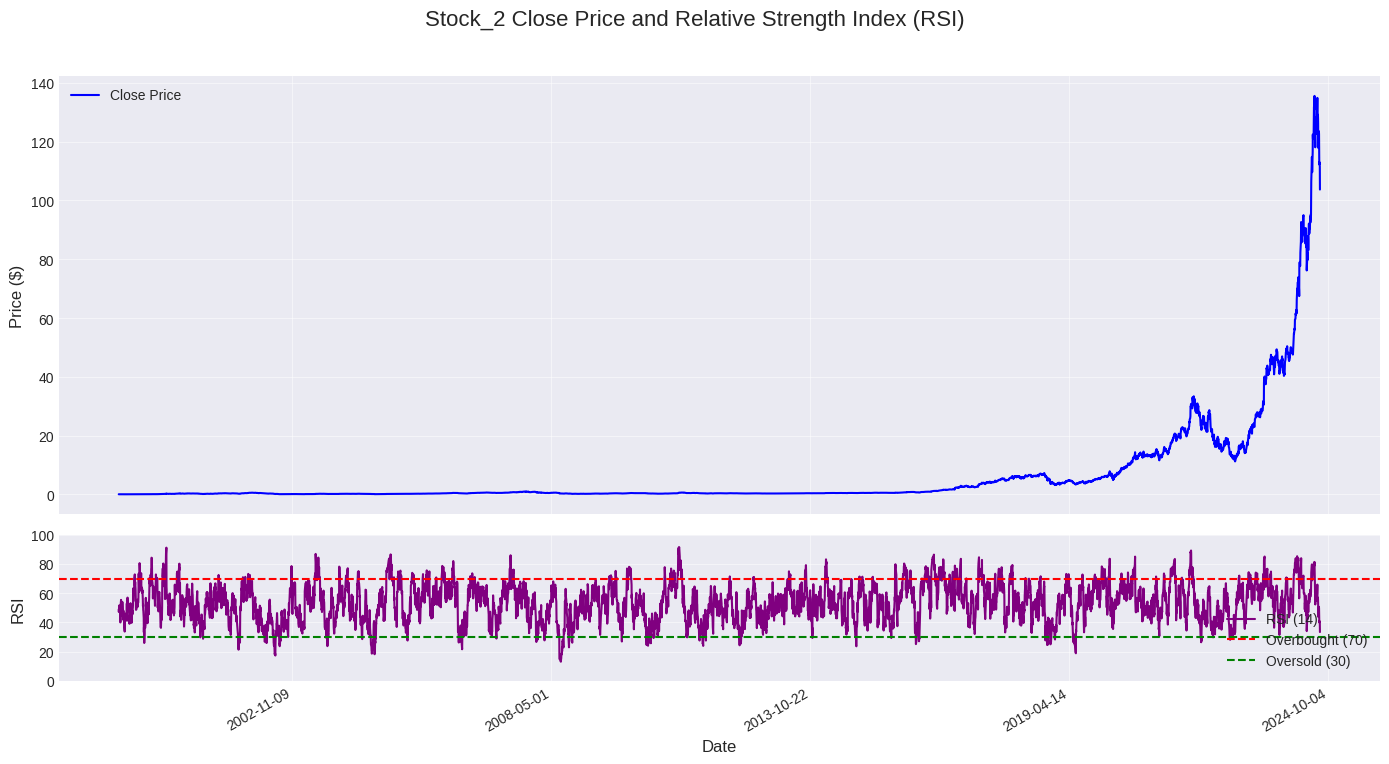

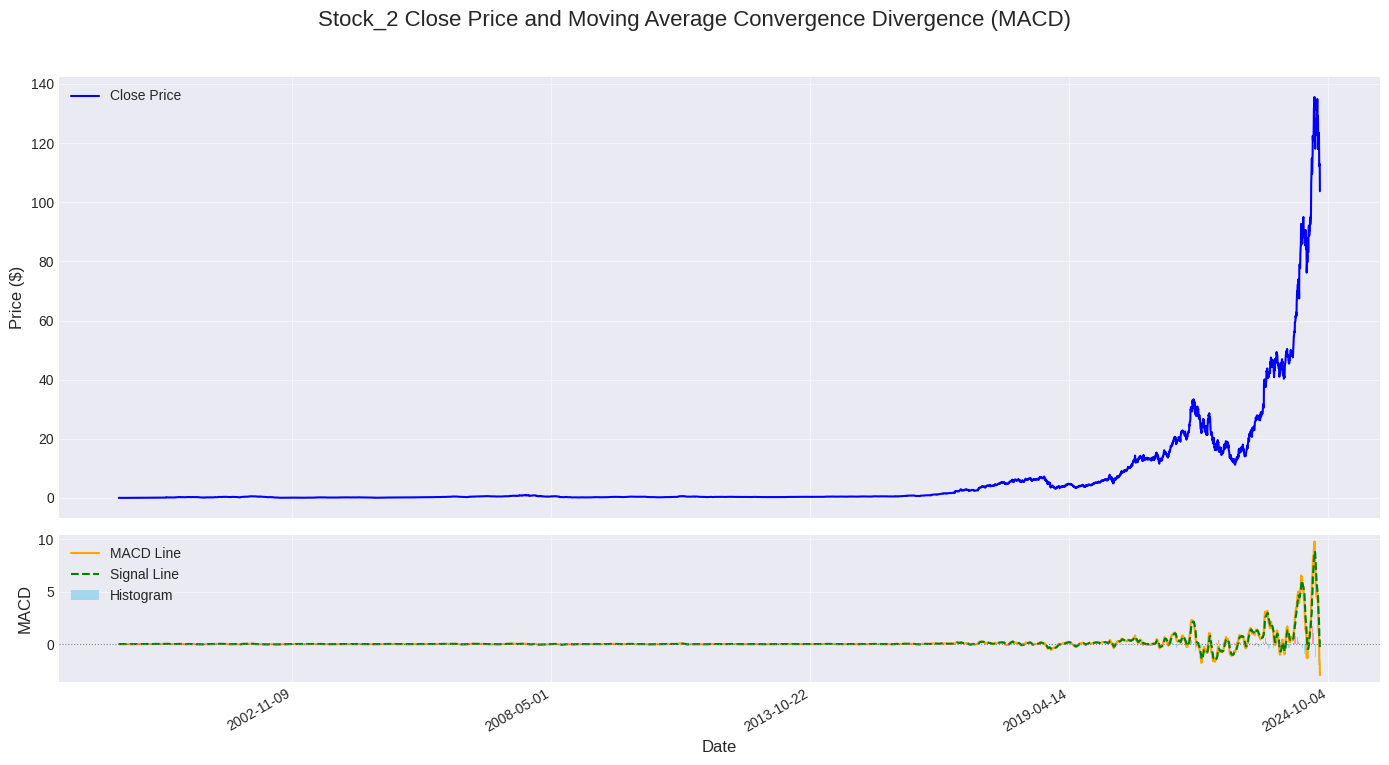

  Visualizations generated for Stock_2.

Generating visualizations for Stock_3...


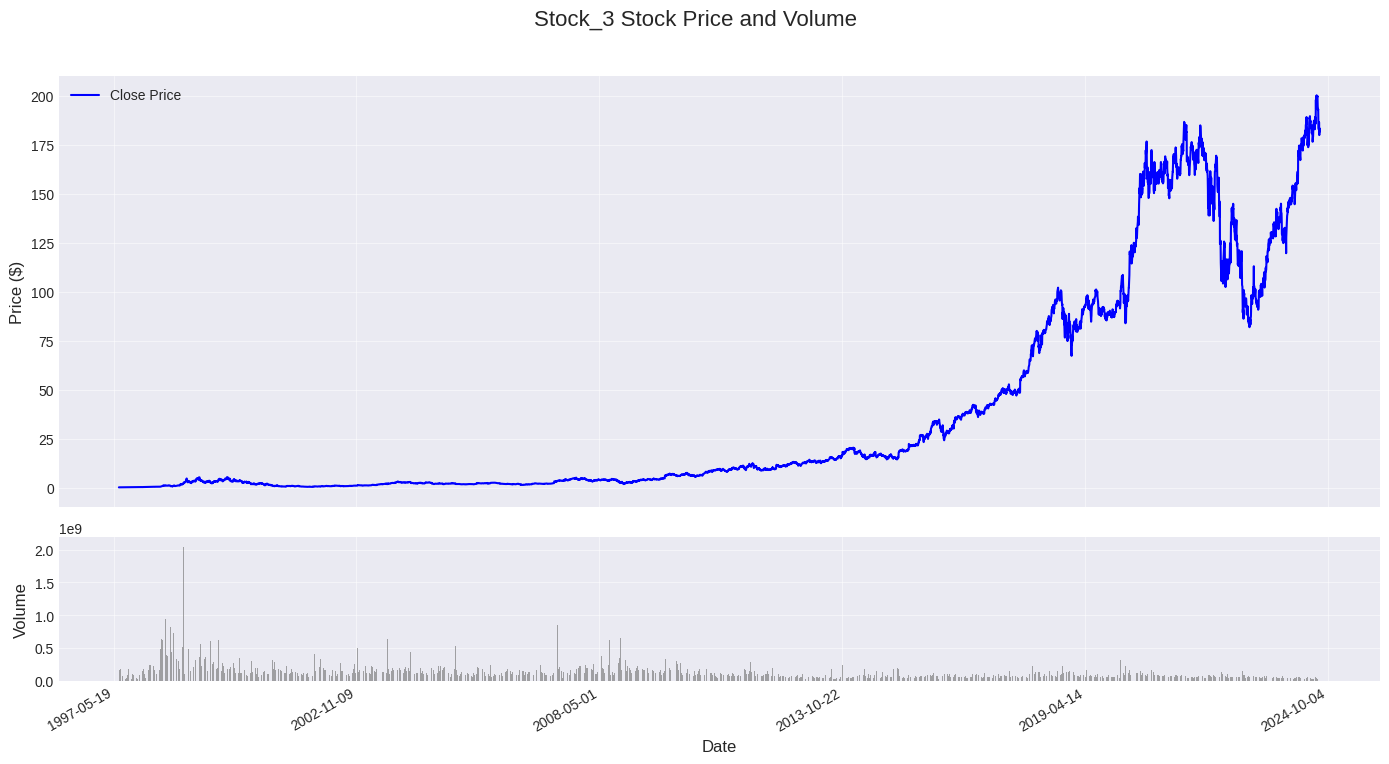

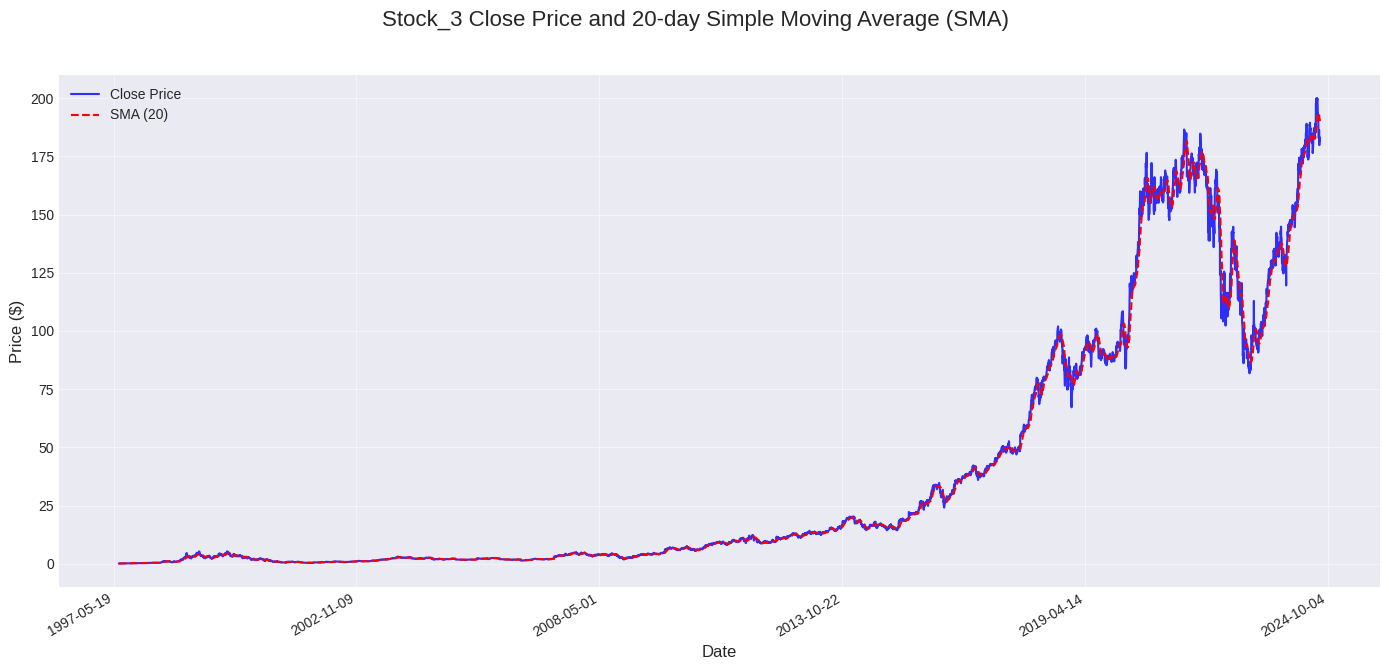

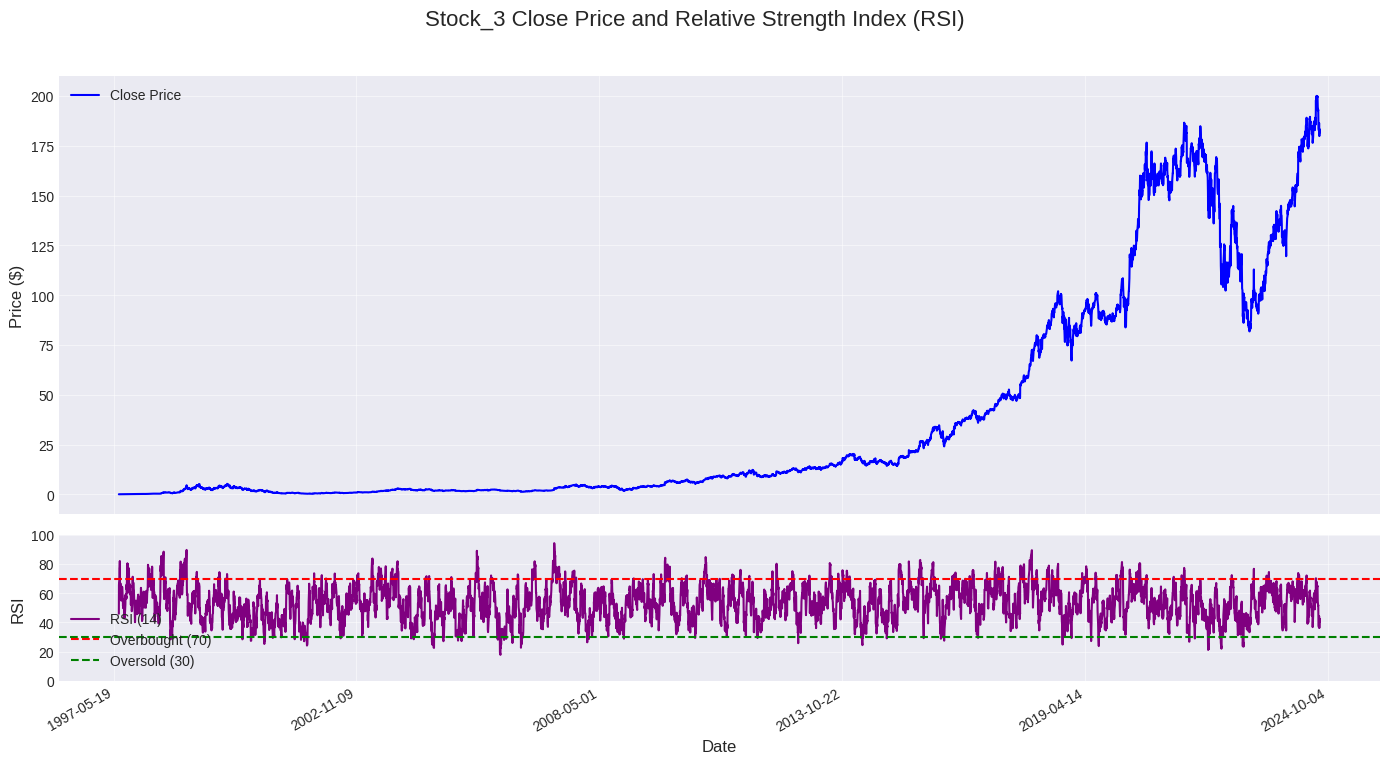

/tmp/ipykernel_3923/27112586.py:143: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])


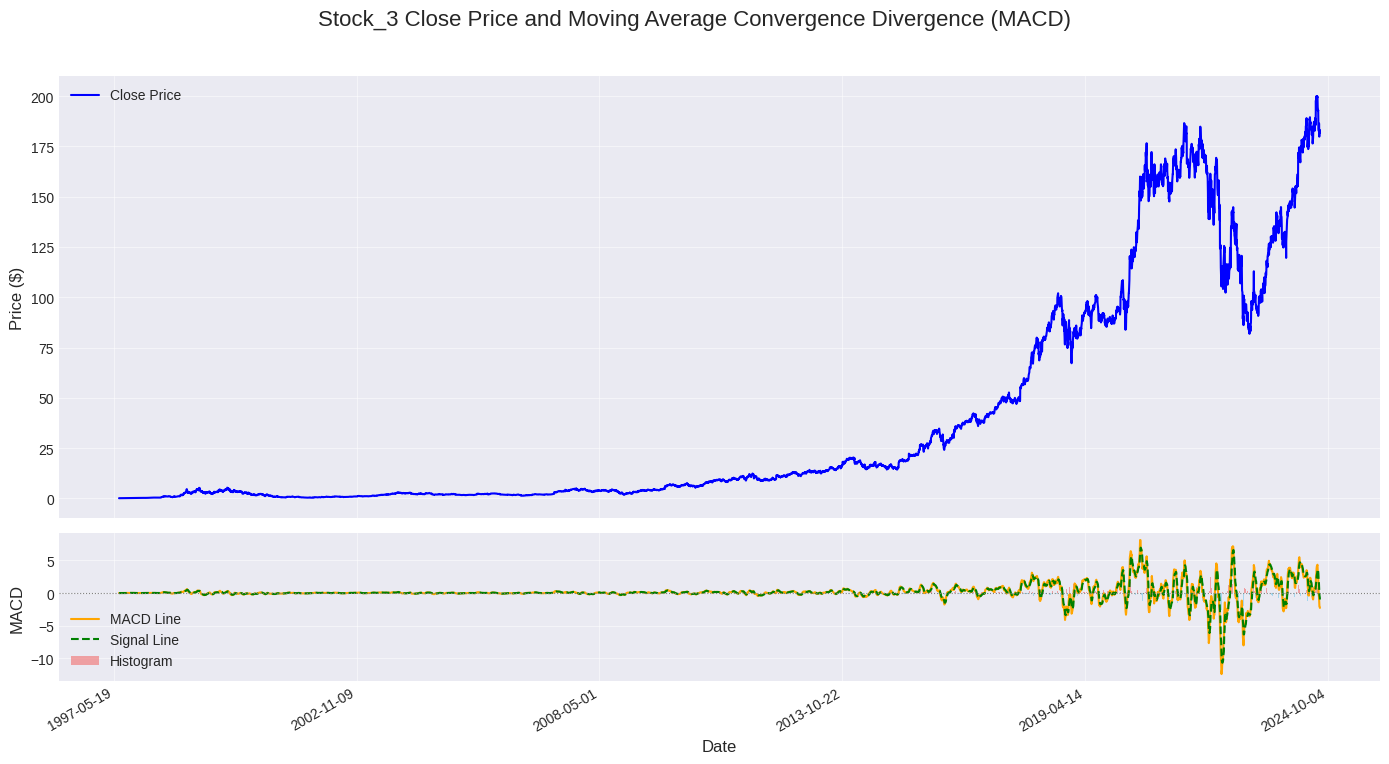

  Visualizations generated for Stock_3.

Generating visualizations for Stock_4...


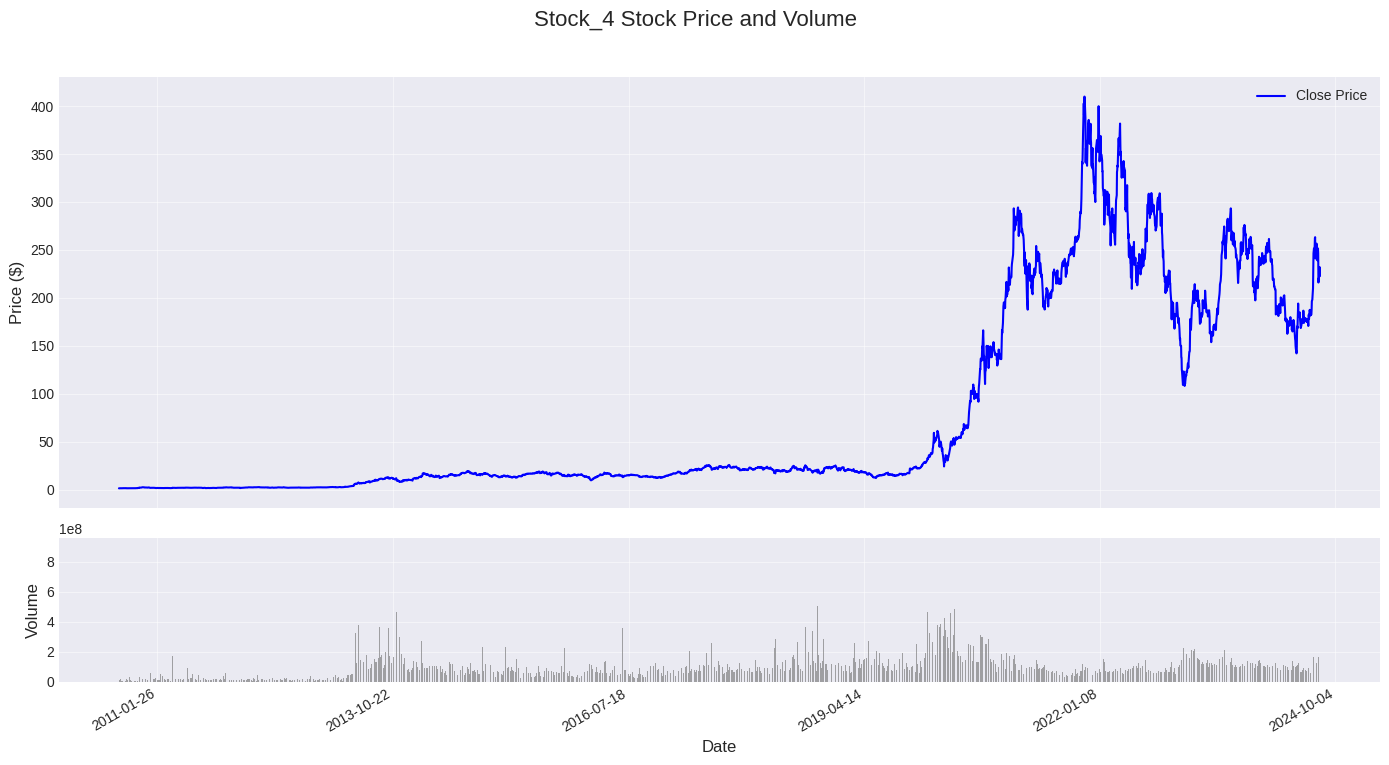

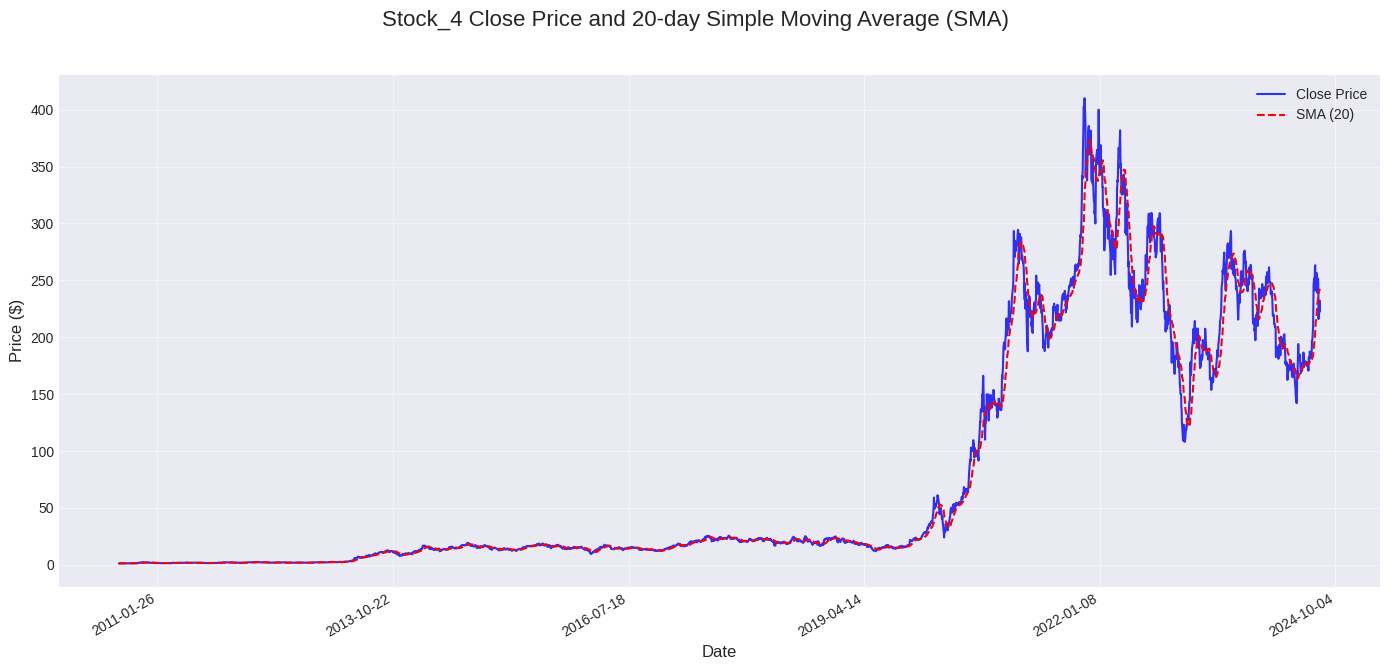

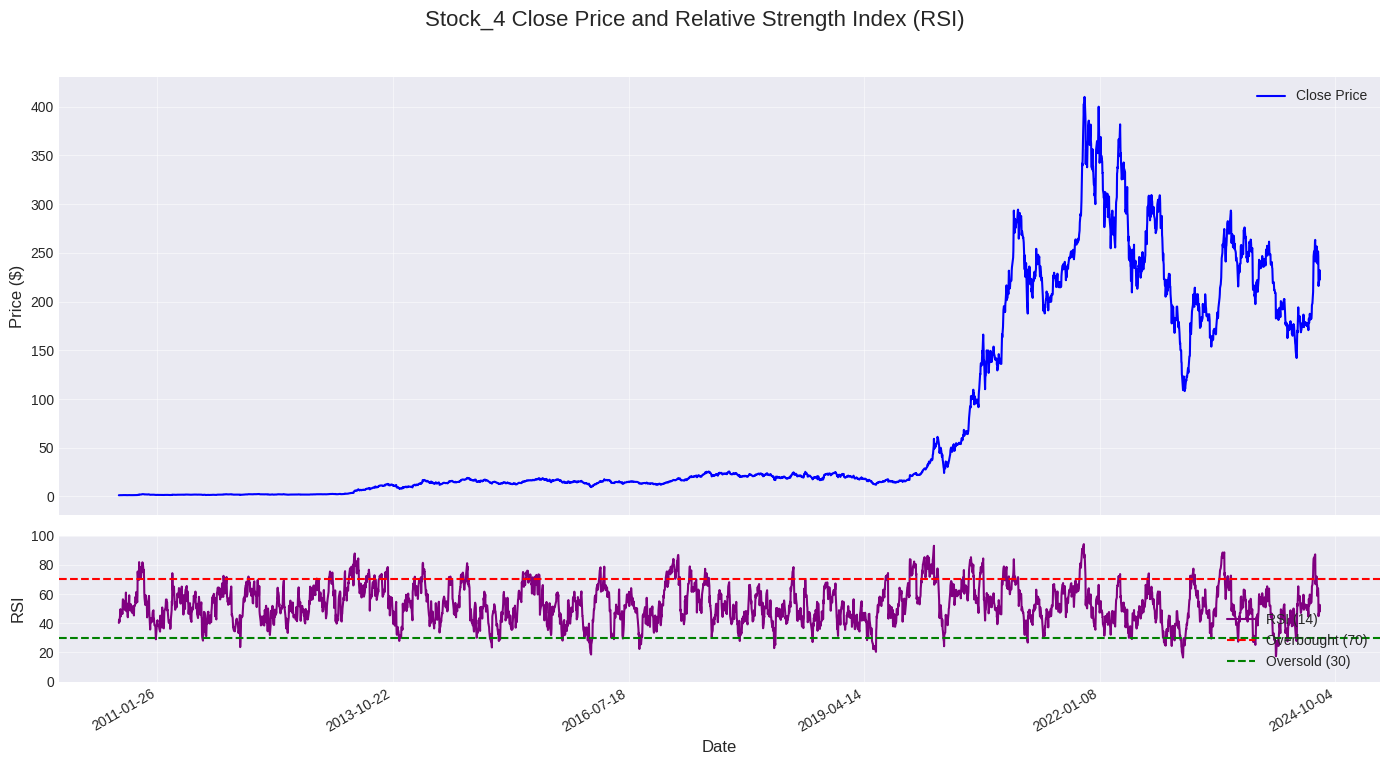

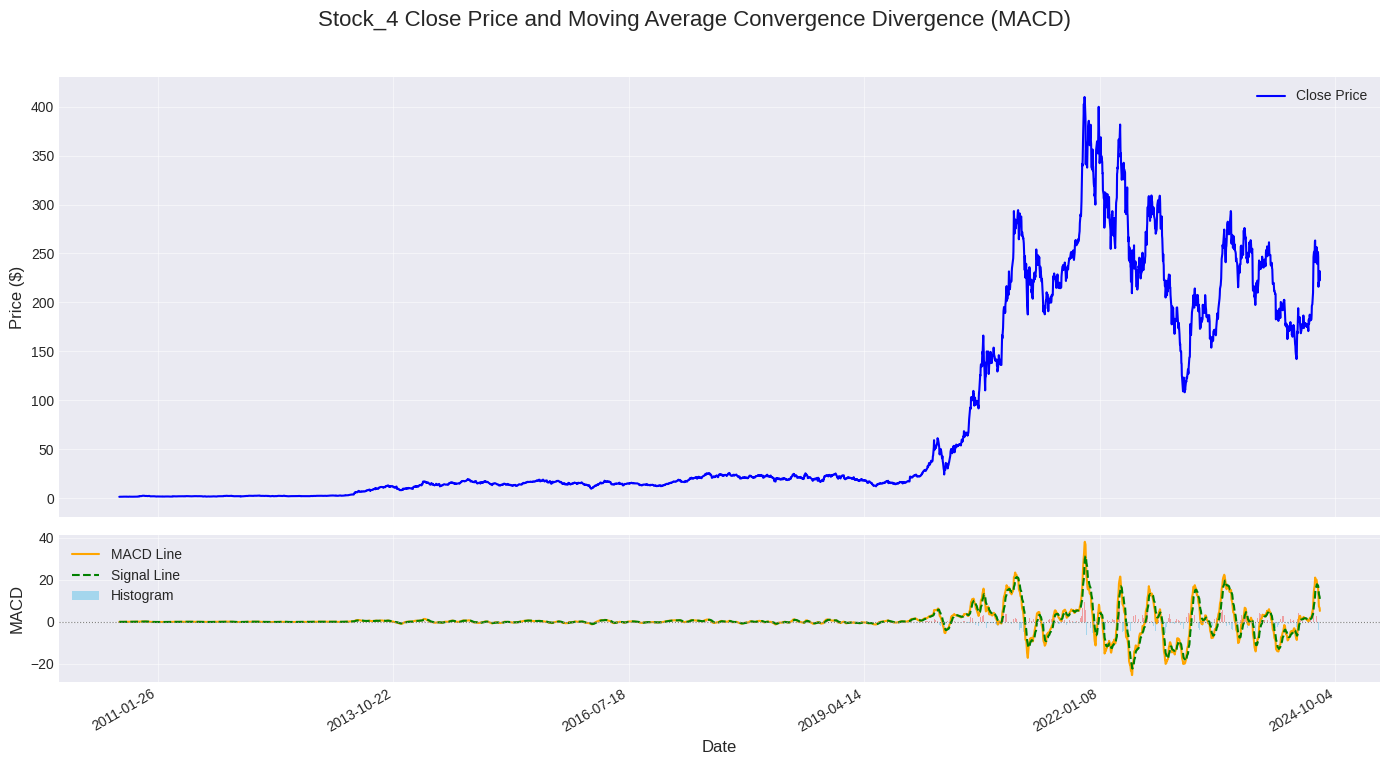

  Visualizations generated for Stock_4.

Generating visualizations for Stock_5...


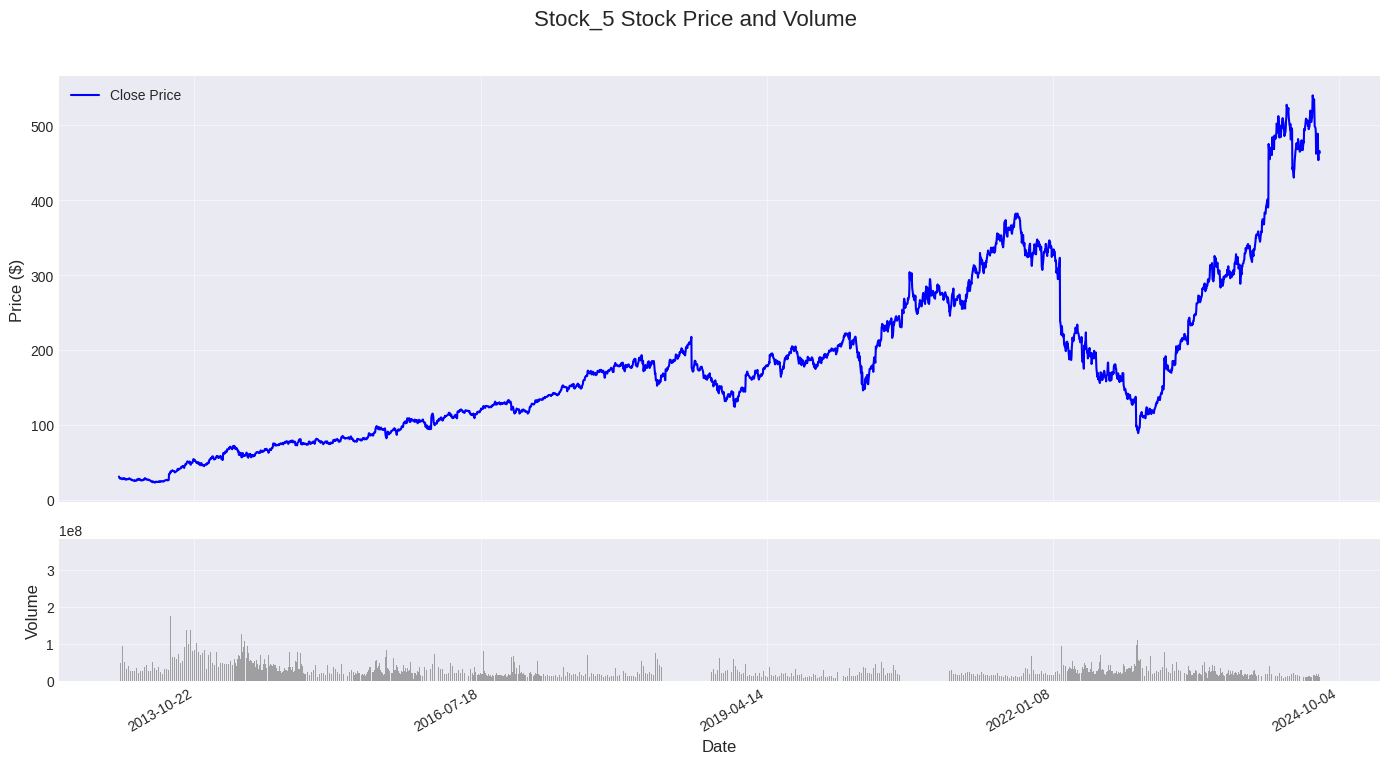

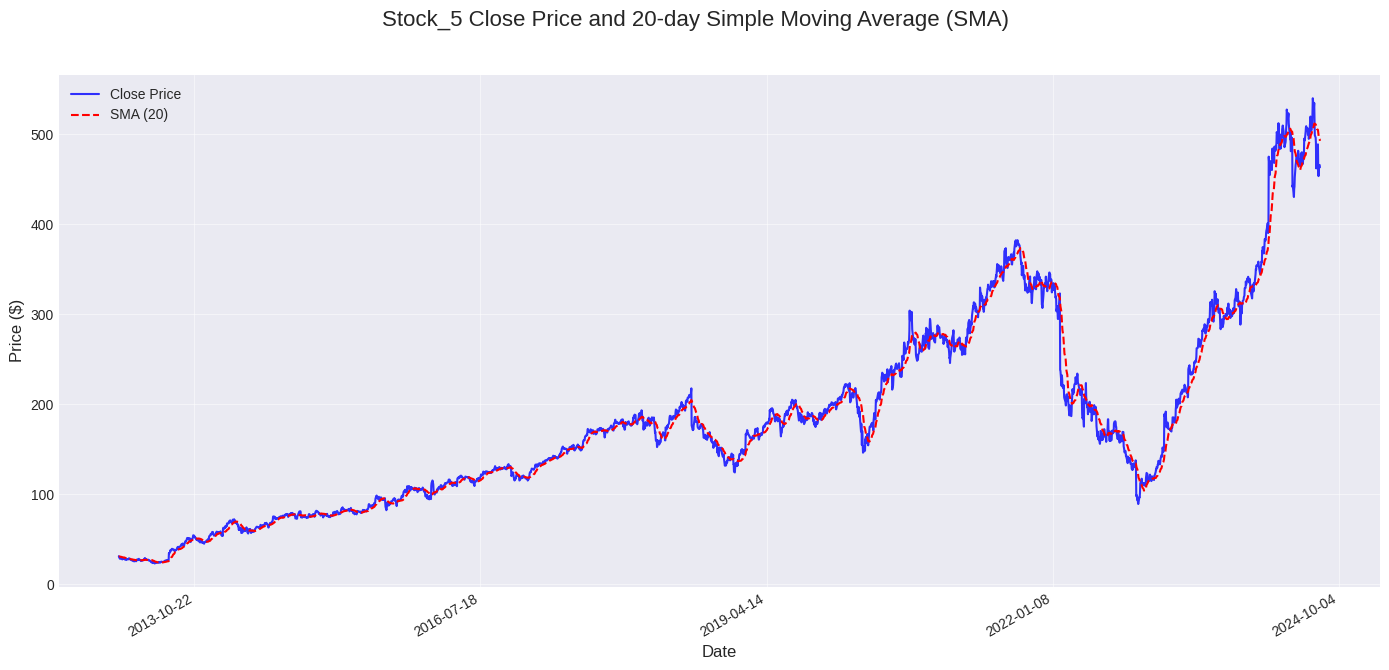

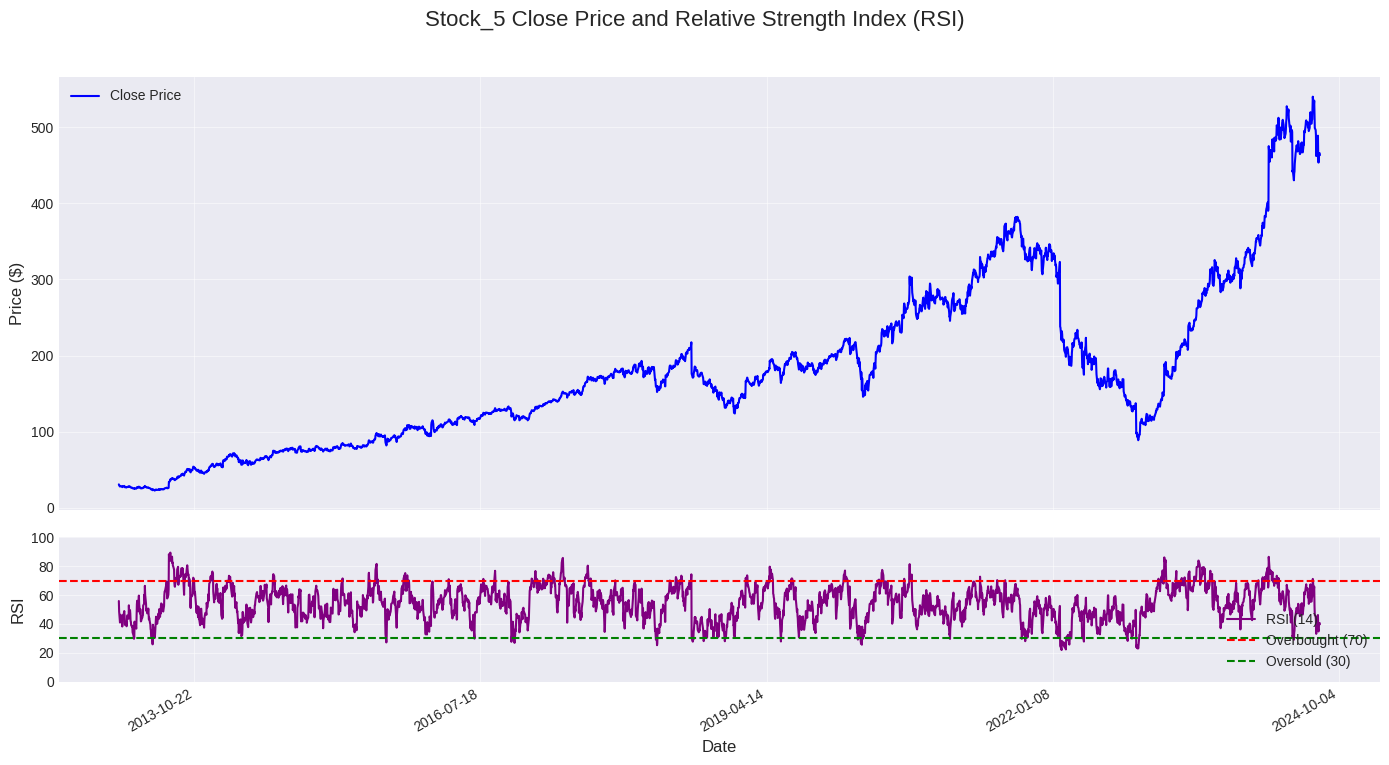

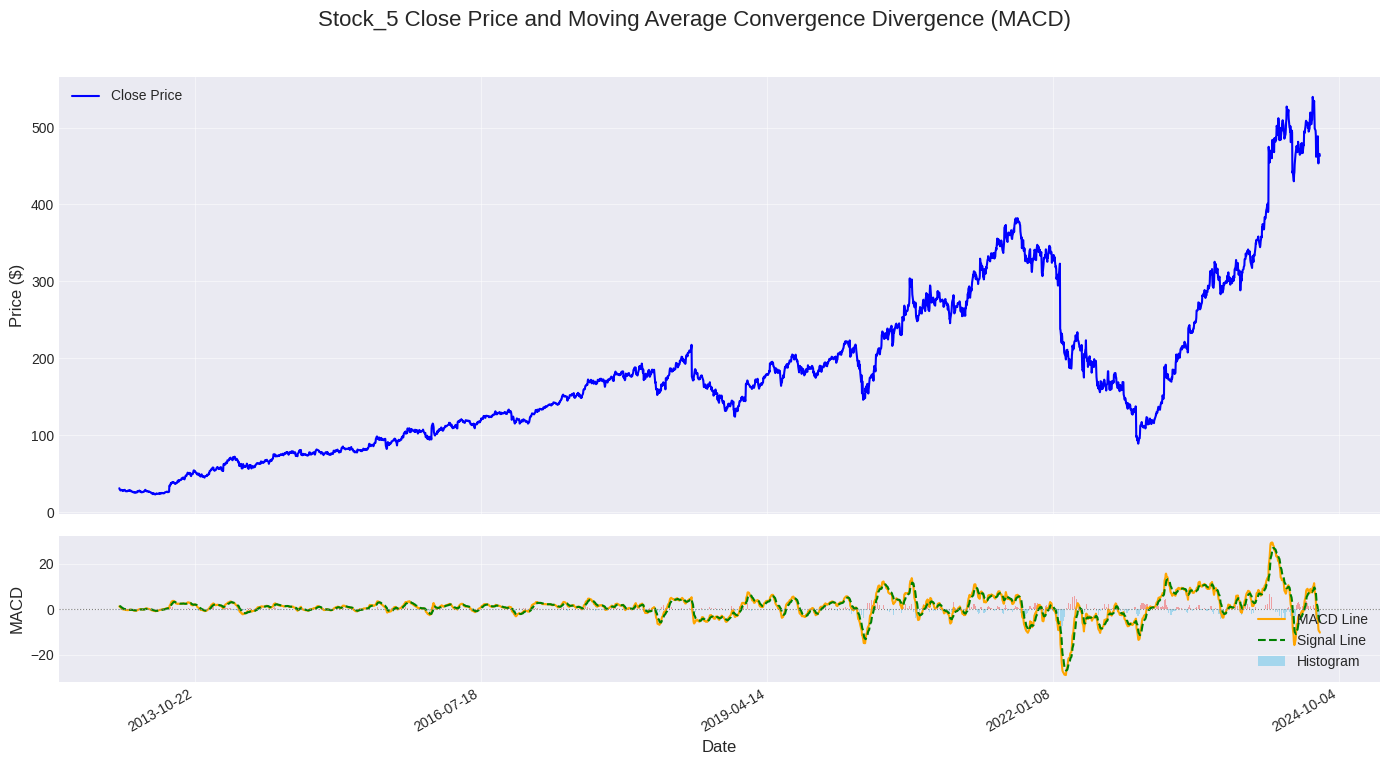

  Visualizations generated for Stock_5.

Generating visualizations for Stock_6...


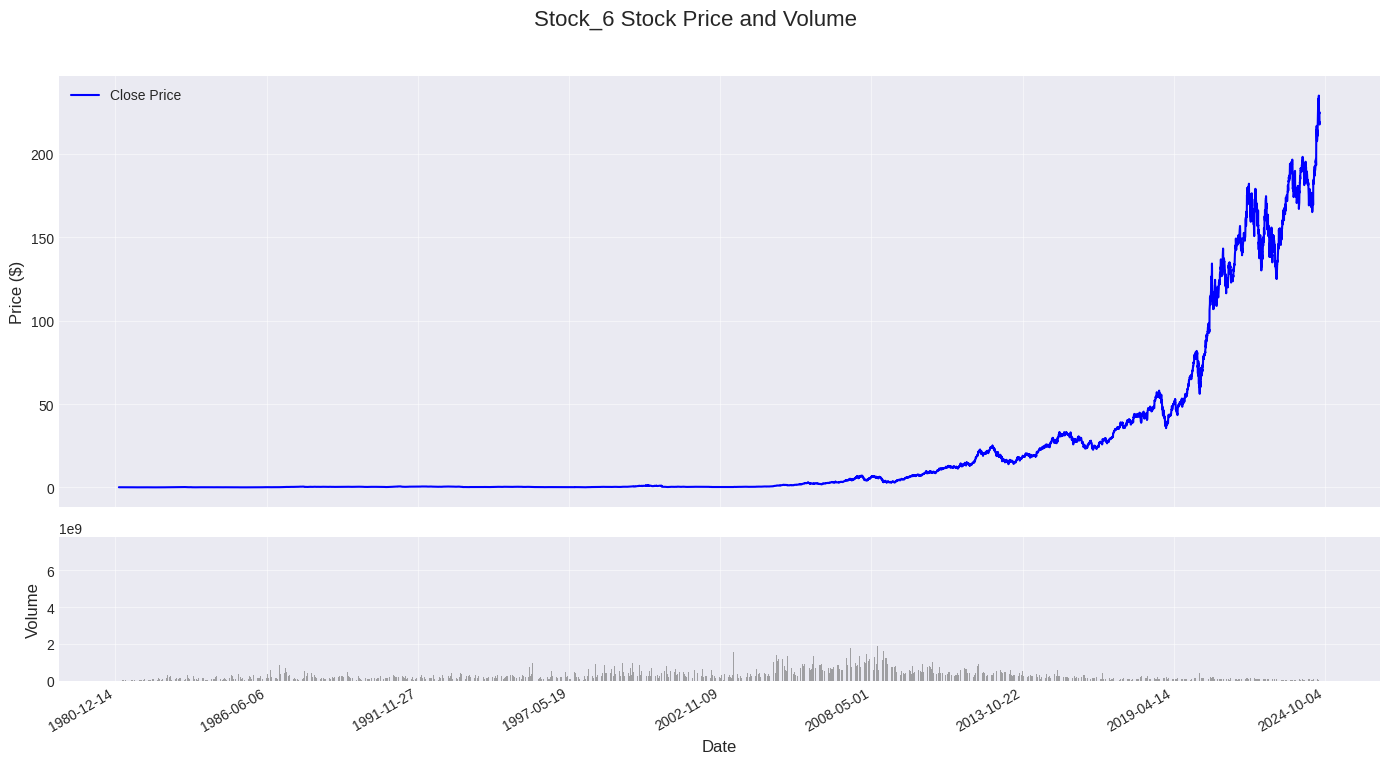

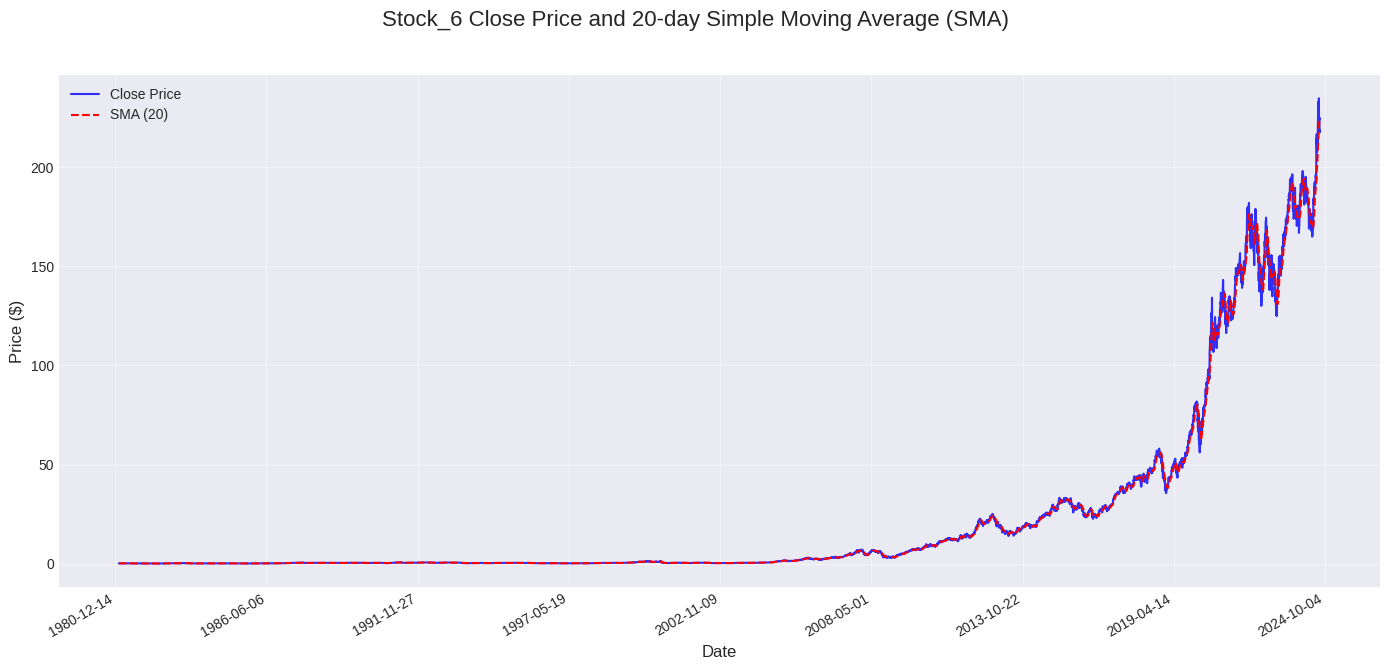

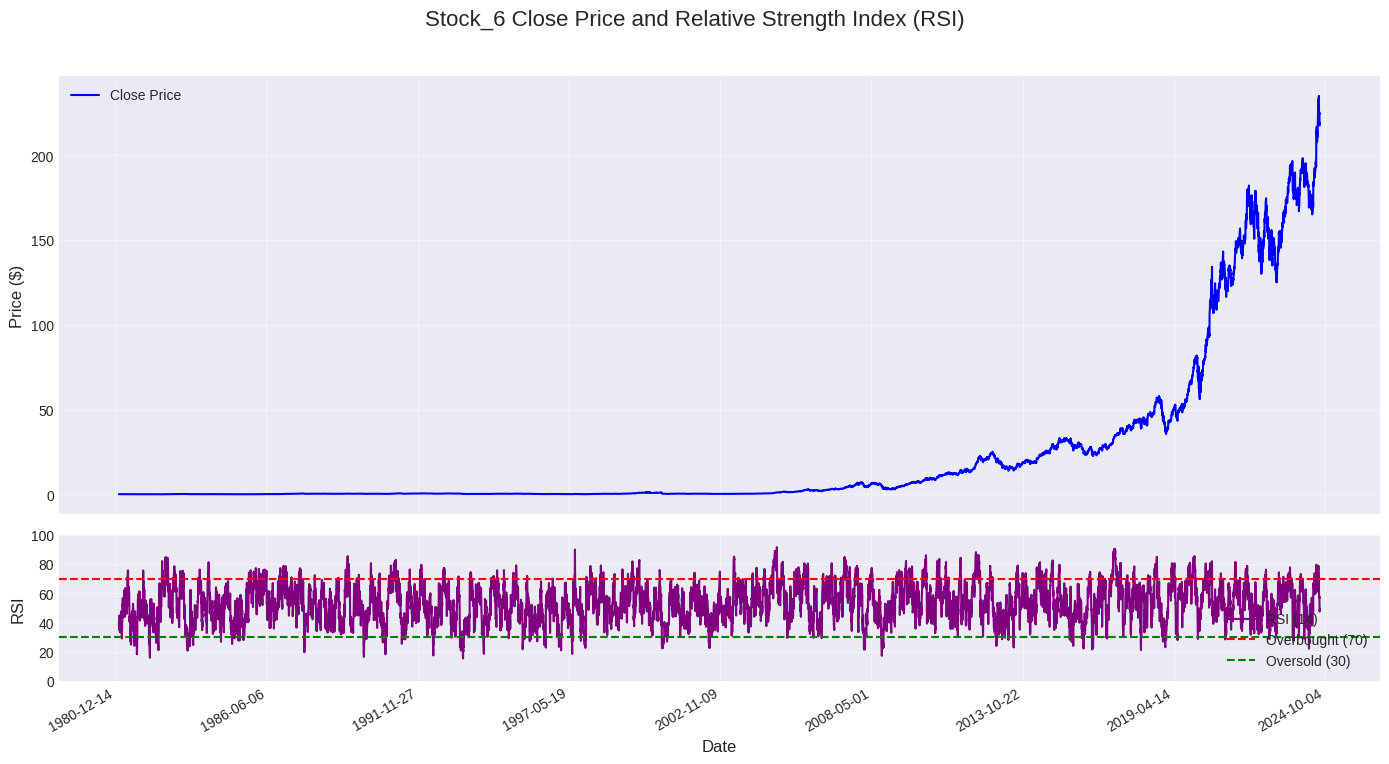

/tmp/ipykernel_3923/27112586.py:143: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout(rect=[0, 0.03, 1, 0.96])
/home/ca/code/KAIM/sentiment-vs-stock_market/.venv/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


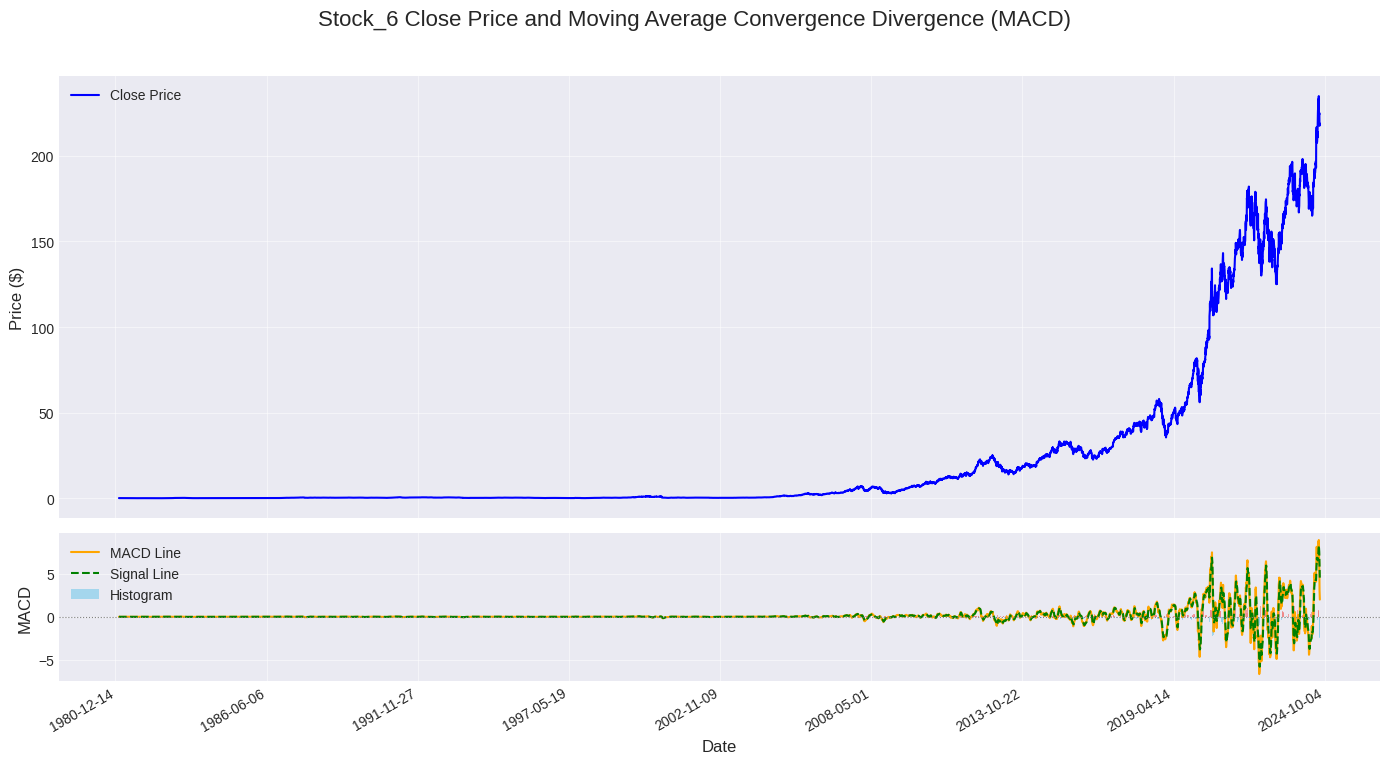

  Visualizations generated for Stock_6.

Generating visualizations for Stock_7...


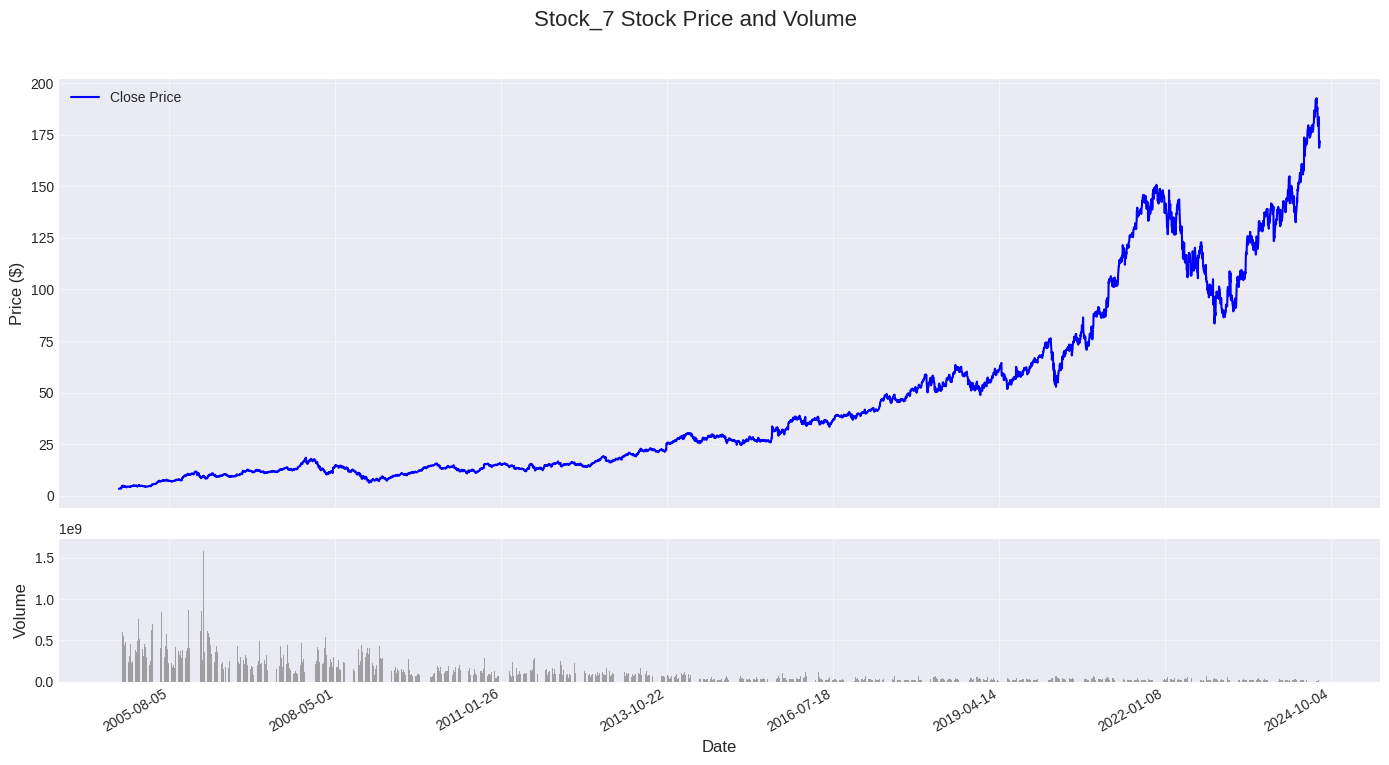

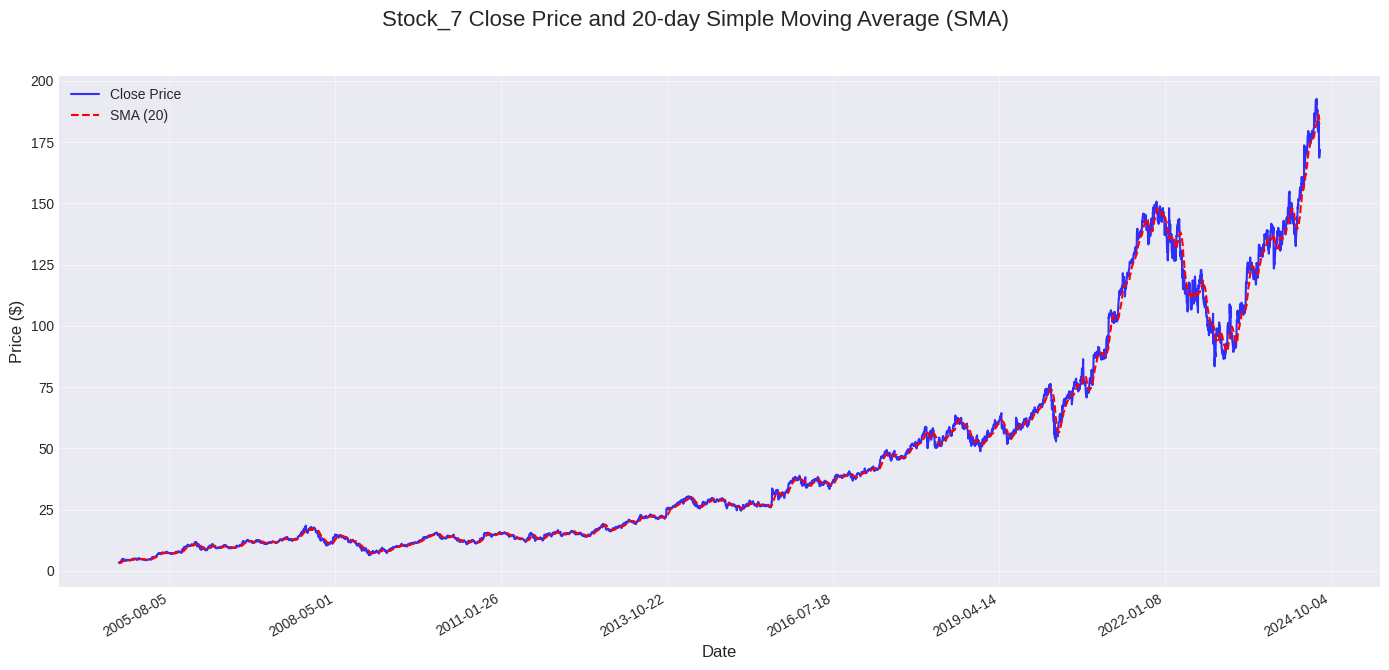

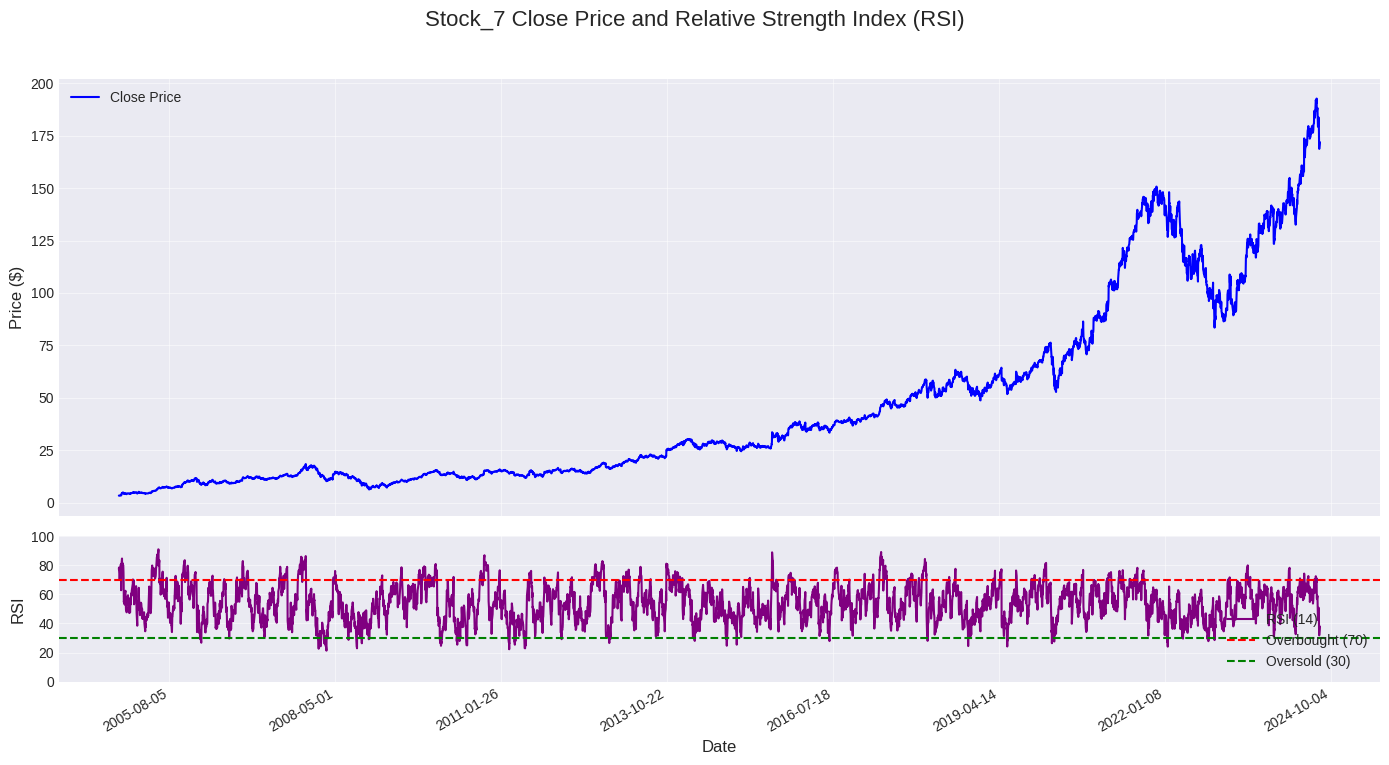

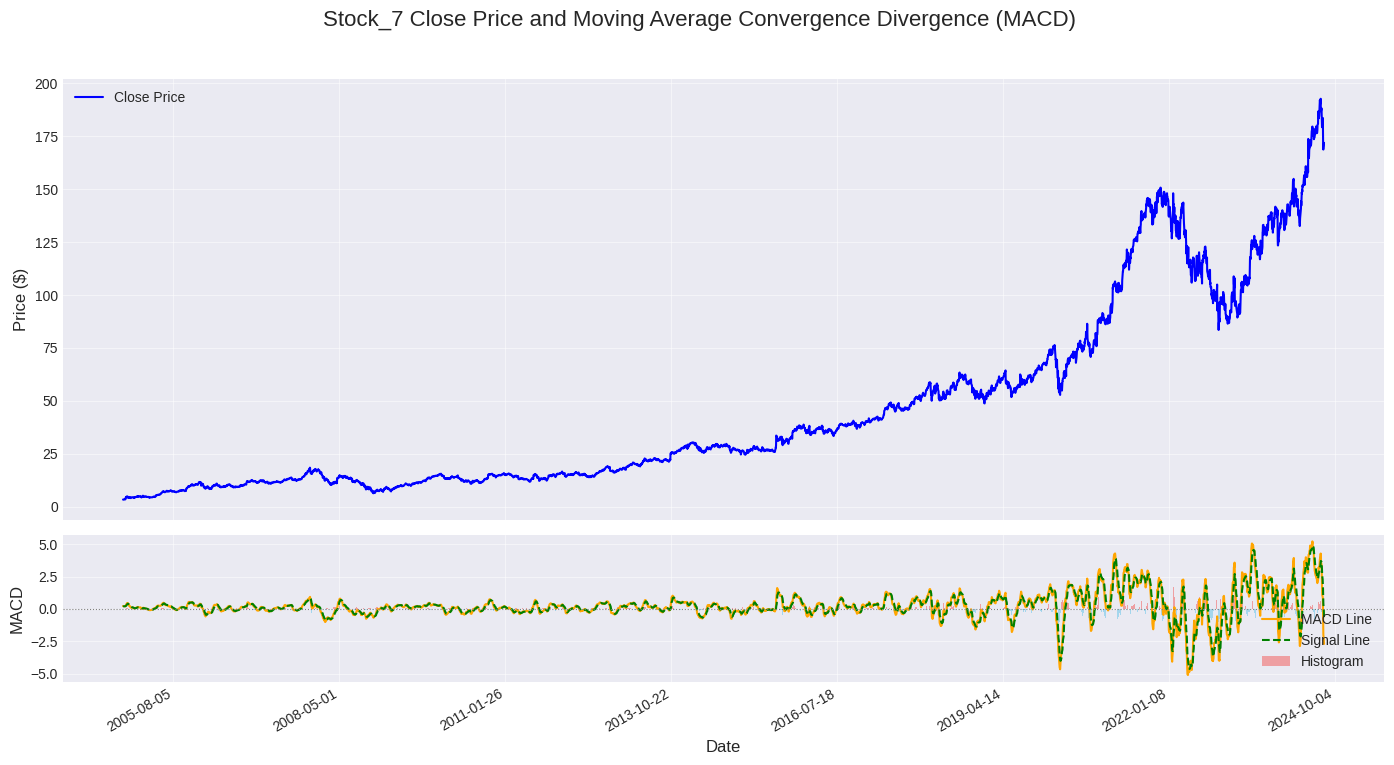

  Visualizations generated for Stock_7.


In [ ]:
import pandas as pd
import numpy as np
import talib as ta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates 
import matplotlib.ticker as mticker # Make sure this is imported

# Assume 'all_yfinance_dfs' is already populated with your actual historical stock data.
# Each DataFrame in all_yfinance_dfs should have 'Open', 'High', 'Low', 'Close', 'Volume' columns and a DatetimeIndex.

print("--- Creating Visualizations for Stock Data and Indicators ---")

if 'all_yfinance_dfs' not in locals() or not all_yfinance_dfs:
    print("Error: 'all_yfinance_dfs' is not loaded or is empty.")
    print("Please ensure your historical stock data is loaded into 'all_yfinance_dfs' before running this code.")
else:
    for i, df_stock in enumerate(all_yfinance_dfs):
        df = df_stock.copy() 
        ticker = df['Ticker'].iloc[0] if 'Ticker' in df.columns else f'Stock_{i+1}'

        print(f"\nGenerating visualizations for {ticker}...")

        required_cols = ['Close', 'Volume', 'SMA_20', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist']
        missing_cols = [col for col in required_cols if col not in df.columns]
        
        if missing_cols:
            print(f"  Warning: Missing columns {missing_cols} in {ticker} DataFrame. Skipping plotting for this stock.")
            continue

        df_plot = df.dropna(subset=['SMA_20', 'RSI_14', 'MACD', 'MACD_Signal', 'MACD_Hist']).copy()

        if df_plot.empty or len(df_plot) < 50: 
            print(f"  Warning: Not enough valid data points ({len(df_plot)}) in {ticker} after dropping NaNs for meaningful plots. Skipping.")
            continue

        # --- Plotting Configuration ---
        plt.style.use('seaborn-v0_8-darkgrid') 
        plt.rcParams['figure.figsize'] = (14, 8) 
        plt.rcParams['lines.linewidth'] = 1.5 
        plt.rcParams['axes.grid'] = True 
        plt.rcParams['grid.alpha'] = 0.5 

        # Format dates on x-axis
        formatter = mdates.DateFormatter('%Y-%m-%d')
        

        locator = mticker.AutoLocator() 
        # Alternatively, you could use:
        # locator = mticker.MaxNLocator(nbins=7) # To explicitly set max number of ticks

        # --- Plot 1: Stock Price and Volume ---
        fig1, (ax1_price, ax1_volume) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        fig1.suptitle(f'{ticker} Stock Price and Volume', fontsize=16)

        # Price Plot
        ax1_price.plot(df_plot.index, df_plot['Close'], label='Close Price', color='blue')
        ax1_price.set_ylabel('Price ($)', fontsize=12)
        ax1_price.legend()
        ax1_price.grid(True)
        ax1_price.xaxis.set_major_formatter(formatter)
        ax1_price.xaxis.set_major_locator(locator) 

        # Volume Plot
        ax1_volume.bar(df_plot.index, df_plot['Volume'], color='gray', alpha=0.7)
        ax1_volume.set_xlabel('Date', fontsize=12)
        ax1_volume.set_ylabel('Volume', fontsize=12)
        ax1_volume.grid(True)
        fig1.autofmt_xdate() 
        plt.tight_layout(rect=[0, 0.03, 1, 0.96]) 
        plt.show()

        # --- Plot 2: Price with SMA ---
        fig2, ax2 = plt.subplots(figsize=(14, 7))
        fig2.suptitle(f'{ticker} Close Price and 20-day Simple Moving Average (SMA)', fontsize=16)
        
        ax2.plot(df_plot.index, df_plot['Close'], label='Close Price', color='blue', alpha=0.8)
        ax2.plot(df_plot.index, df_plot['SMA_20'], label='SMA (20)', color='red', linestyle='--')
        
        ax2.set_ylabel('Price ($)', fontsize=12)
        ax2.set_xlabel('Date', fontsize=12)
        ax2.legend()
        ax2.grid(True)
        ax2.xaxis.set_major_formatter(formatter)
        ax2.xaxis.set_major_locator(locator) 
        fig2.autofmt_xdate()
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

        # --- Plot 3: Price with RSI ---
        fig3, (ax3_price, ax3_rsi) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        fig3.suptitle(f'{ticker} Close Price and Relative Strength Index (RSI)', fontsize=16)

        # Price Plot
        ax3_price.plot(df_plot.index, df_plot['Close'], label='Close Price', color='blue')
        ax3_price.set_ylabel('Price ($)', fontsize=12)
        ax3_price.legend()
        ax3_price.grid(True)
        ax3_price.xaxis.set_major_formatter(formatter)
        ax3_price.xaxis.set_major_locator(locator) 

        # RSI Plot
        ax3_rsi.plot(df_plot.index, df_plot['RSI_14'], label='RSI (14)', color='purple')
        ax3_rsi.axhline(70, color='red', linestyle='--', label='Overbought (70)')
        ax3_rsi.axhline(30, color='green', linestyle='--', label='Oversold (30)')
        ax3_rsi.set_ylabel('RSI', fontsize=12)
        ax3_rsi.set_xlabel('Date', fontsize=12)
        ax3_rsi.set_ylim(0, 100) 
        ax3_rsi.legend()
        ax3_rsi.grid(True)
        fig3.autofmt_xdate()
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

        # --- Plot 4: Price with MACD ---
        fig4, (ax4_price, ax4_macd) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [3, 1]})
        fig4.suptitle(f'{ticker} Close Price and Moving Average Convergence Divergence (MACD)', fontsize=16)

        # Price Plot
        ax4_price.plot(df_plot.index, df_plot['Close'], label='Close Price', color='blue')
        ax4_price.set_ylabel('Price ($)', fontsize=12)
        ax4_price.legend()
        ax4_price.grid(True)
        ax4_price.xaxis.set_major_formatter(formatter)
        ax4_price.xaxis.set_major_locator(locator) 

        # MACD Plot
        ax4_macd.plot(df_plot.index, df_plot['MACD'], label='MACD Line', color='orange')
        ax4_macd.plot(df_plot.index, df_plot['MACD_Signal'], label='Signal Line', color='green', linestyle='--')
        
        # Plot Histogram
        bar_width = (df_plot.index[1] - df_plot.index[0]).days * 0.8 if len(df_plot.index) > 1 else 0.8
        ax4_macd.bar(df_plot.index, df_plot['MACD_Hist'], label='Histogram', 
                     color=np.where(df_plot['MACD_Hist'] >= 0, 'lightcoral', 'skyblue'), 
                     alpha=0.7, width=bar_width) 
        
        ax4_macd.axhline(0, color='gray', linestyle=':', linewidth=0.8) 
        ax4_macd.set_ylabel('MACD', fontsize=12)
        ax4_macd.set_xlabel('Date', fontsize=12)
        ax4_macd.legend()
        ax4_macd.grid(True)
        fig4.autofmt_xdate()
        plt.tight_layout(rect=[0, 0.03, 1, 0.96])
        plt.show()

        print(f"  Visualizations generated for {ticker}.")